(chap_thresholding)=
# Thresholding

:::{admonition} Chapter outline
:class: tip

* **Image segmentation** is the process of detecting **objects** in an image
* **Global thresholding** identifies pixel values above or below a particular threshold
* The choice of threshold can introduce **bias**
* **Automated thresholding methods** can often determine a good threshold based upon the **image histogram** and **statistics** -- but only if certain assumptions are met
* Thresholding is more powerful when combined with **filtering & subtraction**
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

Before we can measure anything in an image, we first need to detect it.

Sometimes, 'detection' might involve [manually drawing regions of interest (ROIs)](chap_rois).
However, this laborious process does not scale very well.
It can also be rather subjective.

In this chapter, we will begin to explore alternative ways to identify **objects** within images.
An 'object' is something we want to detect; depending upon the application, an object might be a nucleus, a cell, a vessel, a person, a bird, a car, a helicopter... more or less anything we might find in an image.

This process of detecting objects is called **image segmentation**.
If we can automate image segmentation, this is not only likely to be much faster than manually annotating regions but should also give more reproducible results.

(sec_binary_labeled)=
## Binary & labeled images

Image objects are commonly represented using **binary images**.

Each pixel in a binary image can have one of two values.
Usually, these values are 0 and 1.
In some software (including ImageJ) a binary image has the values 0 and 255, but this doesn't really make any difference to how it is used: the key point for our purposes is that one of the values represents the foreground (i.e. pixels that are part of an object), and the other value represents the background.

For the rest of this chapter, we will assume that our binary images use 0 for the background (shown as black) and 1 for the foreground (shown as white).

This is important: if we can generate a binary image in which all our objects of interest are in the foreground, we can then use this binary image to help us make measurements of those objects.

One way to do this involves identifying individual objects in the binary image by labeling **connected components**.
A connected component is really just a connected group of foreground pixels, which together represent a distinct object.
By labeling connected components, we get a **labeled image** in which the pixels belonging to each object have a unique integer value.
All the pixels with the same value belong either to the background (if the value is 0) or to the same object.

If required, we can then trace the boundaries of each labeled object to create **regions of interest (ROIs)**, such as those used to make measurement in ImageJ and other software.

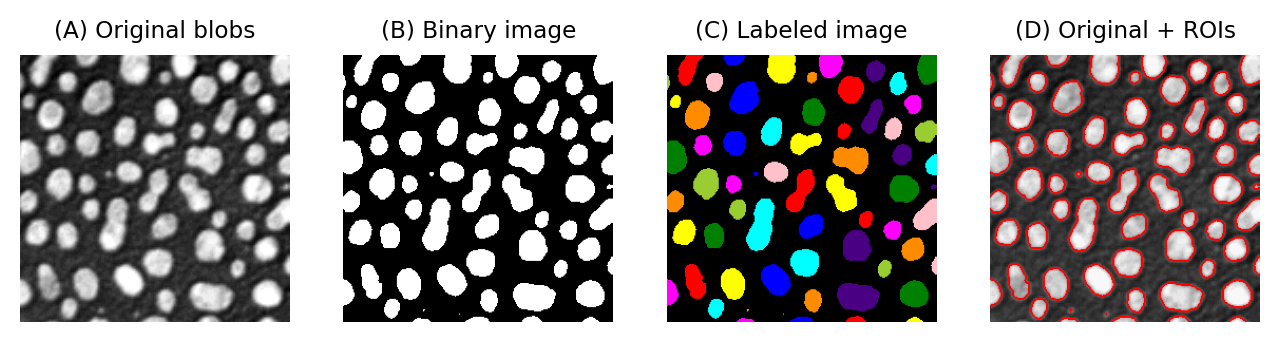

In [2]:
"""
Show binary image, ROIs and labelled image.
"""

from skimage.filters import threshold_otsu, threshold_triangle
from skimage.color import label2rgb
from skimage.segmentation import mark_boundaries

im = 255 - load_image('blobs.gif')
bw = im > threshold_otsu(im)
lab, n = ndimage.label(bw)

fig = create_figure(figsize=(8, 4))

show_image(im, title="(A) Original blobs", pos=141)
show_image(bw, title="(B) Binary image", pos=142)
show_image(label2rgb(lab, bg_label=0), title="(C) Labeled image", pos=143)
show_image(mark_boundaries(im, lab, mode='thick', color=(1, 0, 0)), title="(D) Original + ROIs", pos=144)
glue_fig('fig_blobs_binary_label', fig)

```{glue:figure} fig_blobs_binary_label
---
align: center
name: fig-blobs_binary_label
---
Examples of a grayscale (blobs.gif), binary and labelled image.
In (C), each label has been assigned a unique color for display.
In (D), ROIs have been generated from (C) and superimposed on top of (A).
It is common to use a LUT for labeled images that assigns a different color to each pixel value.
```

For that reason, a lot of image analysis workflows involve binary images along the way.
Most of this chapter will explore the most common way of generating a binary image: **thresholding**.

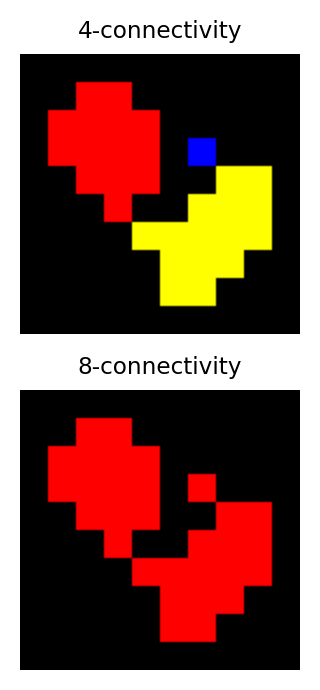

In [3]:
"""
Compare 4-connectivity and 8-connectivity
"""

from skimage.color import label2rgb

bw = load_image("images/connectivity_binary.png")

lab4, n = ndimage.label(bw)
lab8, n = ndimage.label(bw, structure=np.ones((3, 3)))

fig = create_figure(figsize=(2, 4))
show_image(label2rgb(lab4, bg_label=0), title="4-connectivity", pos=211)
show_image(label2rgb(lab8, bg_label=0), title="8-connectivity", pos=212)
# plt.tight_layout()
glue_fig('fig_thresholding_connectivity', fig)

````{margin}
```{glue:figure} fig_thresholding_connectivity
:figwidth: 60%
:align: center
```
````

(sec_thresholds_connectivity)=
:::{admonition} Connectivity
:class: info

Identifying multiple objects in a binary image involves separating distinct groups of pixels that are considered 'connected' to one another, and then creating a ROI or label for each group.
Connectivity in this sense can be defined in different ways.
For example, if two pixels have the same value and are immediately beside one another (above, below, to the left or right, or diagonally adjacent) then they are said to be _8-connected_, because there are 8 different neighboring locations involved.
Pixels are _4-connected_ if they are horizontally or vertically adjacent, but _not_ only diagonally.

The choice of connectivity can make a big difference in the number and sizes of objects found, as the example on the right shows (distinct objects are shown in different colors).
:::

````{tab-set}

```{tab-item} Question


What do you suppose _6-connectivity_ and _26-connectivity_ refer to?
```

```{tab-item} Answer
6-connectivity is similar to 4-connectivity, but in 3D.
If all 3D diagonals are considered, we end up with each pixel having 26 neighbors.
```

````

## Global thresholding

The easiest way to segment an image is by applying a **global threshold**.
This identifies pixels that are above or below a fixed threshold value, giving a binary image as the output.

Global thresholding can be thought of as a [point operation](chap_point_operations) because the output is based solely on the value of each pixel, and not its location or its neighbors.
For a global threshold to work, the pixels inside objects need to have higher or lower values than the other pixels.
We will look at image processing tricks to overcome this limitation later, but for now we will focus on examples where we want to detect objects have values that are clearly distinct from the background -- and so global thresholding could potentially work.

### Thresholding using histograms

It's possible to tell quite a lot about an image just by looking at its histogram.

Take the following example:

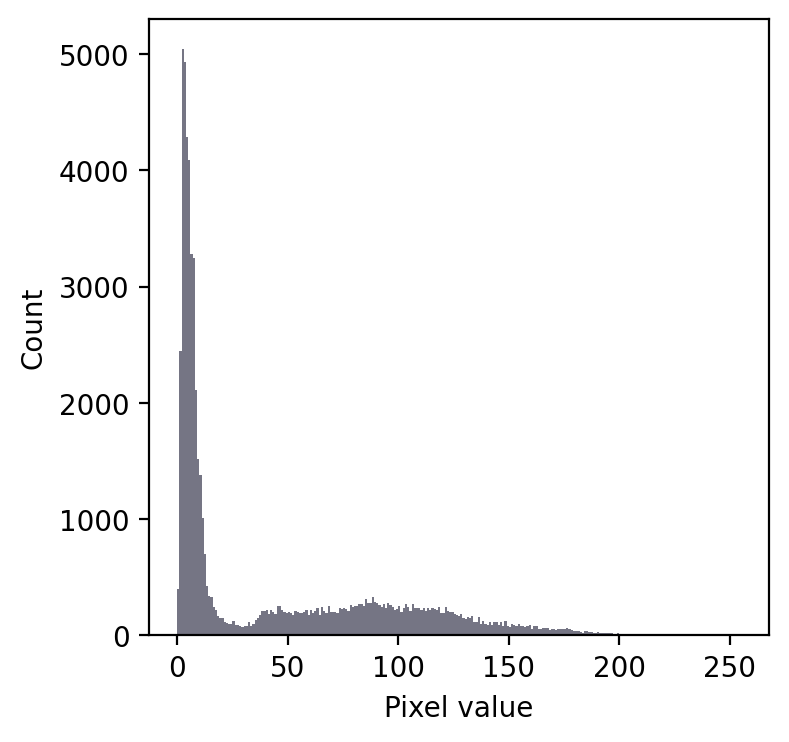

In [4]:
def convert_to_uint8(im: np.ndarray):
    im = im - im.min()
    im = im / im.max()
    return (im * 255).astype(np.uint8)    

def load_nuclei(to_uint8=True, noise_sigma=None, do_square=False):
    if do_square:
        im = load_image('hela-cells.zip')[10:330, 210:530, 2].astype(np.float32)
    else:
        im = load_image('hela-cells.zip')[80:280, 210:530, 2].astype(np.float32)
    if noise_sigma:
        im = im + np.random.default_rng(100).normal(scale=noise_sigma, size=im.shape)
    if to_uint8:
        return convert_to_uint8(im)
    return im

# Load image & show histogram
im = load_nuclei()

fig = create_figure(figsize=(4, 4))
show_histogram(im, bins=np.arange(0, 256))

glue_fig('fig_thresholds_nuclei_histogram_only', fig)

```{glue:figure} fig_thresholds_nuclei_histogram_only
---
align: center
name: fig-thresholds_nuclei_histogram_only
figwidth: 50%
---
```

Even without seeing the image, we can make some educated guesses about its contents.

Firstly, there is a large peak to the left and a much shallower peak to the right.
This suggests that there are at least two distinct regions in the image.
Since the background of an image tends to contain many pixes with similar values, I would guess that we might have an image with a dark background.

In any case, a threshold around 20-25 looks like it would be a good choice to separate the regions... whatever they may be.

If we then look at the image, we can see that we have in fact got a fluorescence image depicting two nuclei.
Applying a threshold of 20 does achieve a good separation of the nuclei from the background: a successful segmentation.

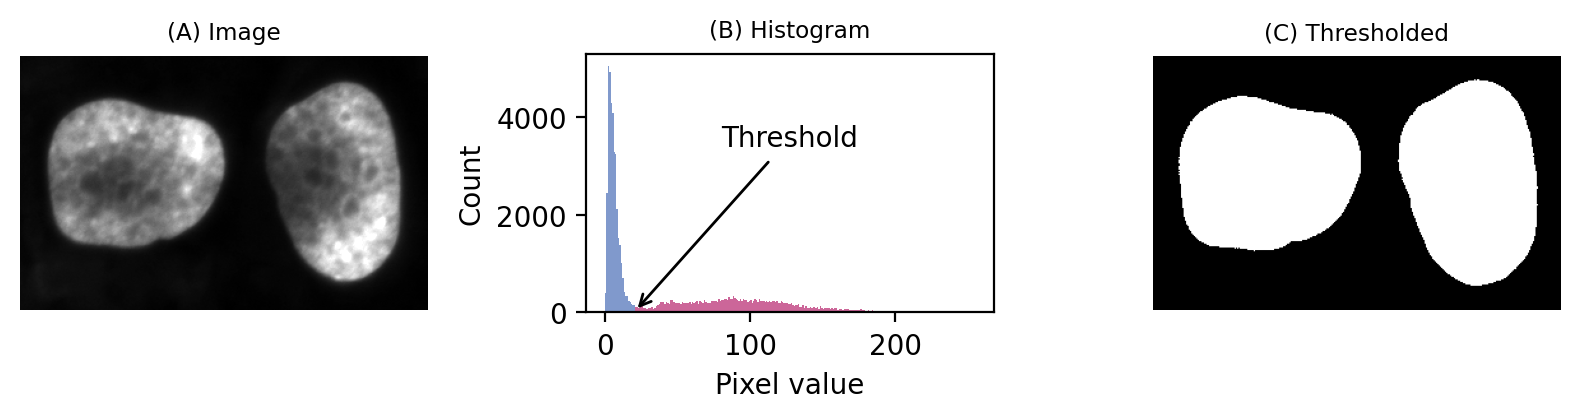

In [5]:
# Load image & set threshold
im = load_nuclei()
thresh = 20

# Show results
fig = create_figure(figsize=(8, 2.2))
show_image(im, title="(A) Image", clip_percentile=0.5, pos=131)
show_histogram(im[im <= thresh], title="(B) Histogram", bins=np.arange(0, 256), color=(0.5, 0.6, 0.8), pos=132)
plt.hist(im[im > thresh].flatten(), bins=np.arange(0, 256), color=(0.8, 0.4, 0.6))
plt.annotate('Threshold', (thresh, 0), xytext=(80, 3400), arrowprops=dict(arrowstyle='->'))
show_image(im > thresh, title="(C) Thresholded", pos=133)

plt.tight_layout()

glue_fig('fig_thresholds_nuclei_histogram', fig)

```{glue:figure} fig_thresholds_nuclei_histogram
---
align: center
name: fig-thresholds_nuclei_histogram
---
A simple fluorescence image containing two nuclei. We could determine a potentially useful threshold based only on looking at the histogram.
```

Admittedly, that was a particularly easy example.
We should try a slightly harder one.

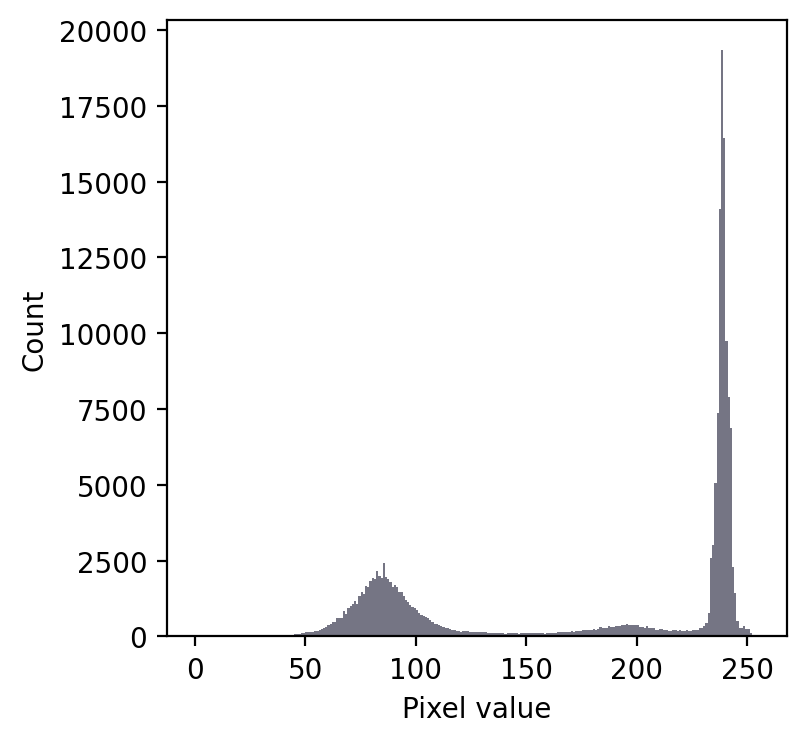

In [6]:
def load_leaf():
    im = load_image('leaf.jpg')[80:, ...]
    im = im.mean(axis=-1).astype(np.uint8)
    return im

# Load image & show histogram
im = load_leaf()
fig = create_figure(figsize=(4, 4))
show_histogram(im, bins=np.arange(0, 256))

glue_fig('fig_thresholds_leaf_histogram_only', fig)

```{glue:figure} fig_thresholds_leaf_histogram_only
---
align: center
name: fig-thresholds_leaf_histogram_only
figwidth: 40%
---
```

We still have a large peak, but this time it is towards the right.
So I would guess a light background rather than a dark one.

But the problem is that we seem to have *two* shallower peaks to the left.
That suggests at least three different classes of pixels in the image.

From visual inspection, we might suppose a threshold of 140 would make sense.
Or perhaps around 220.
It isn't clear.

This time, we *do* need to look at the image to decide.
Even then, there is no unambiguously 'correct' threshold.
Rather, the one we choose depends upon whether our goal is to identify the entire leaf or rather just the darkest region.

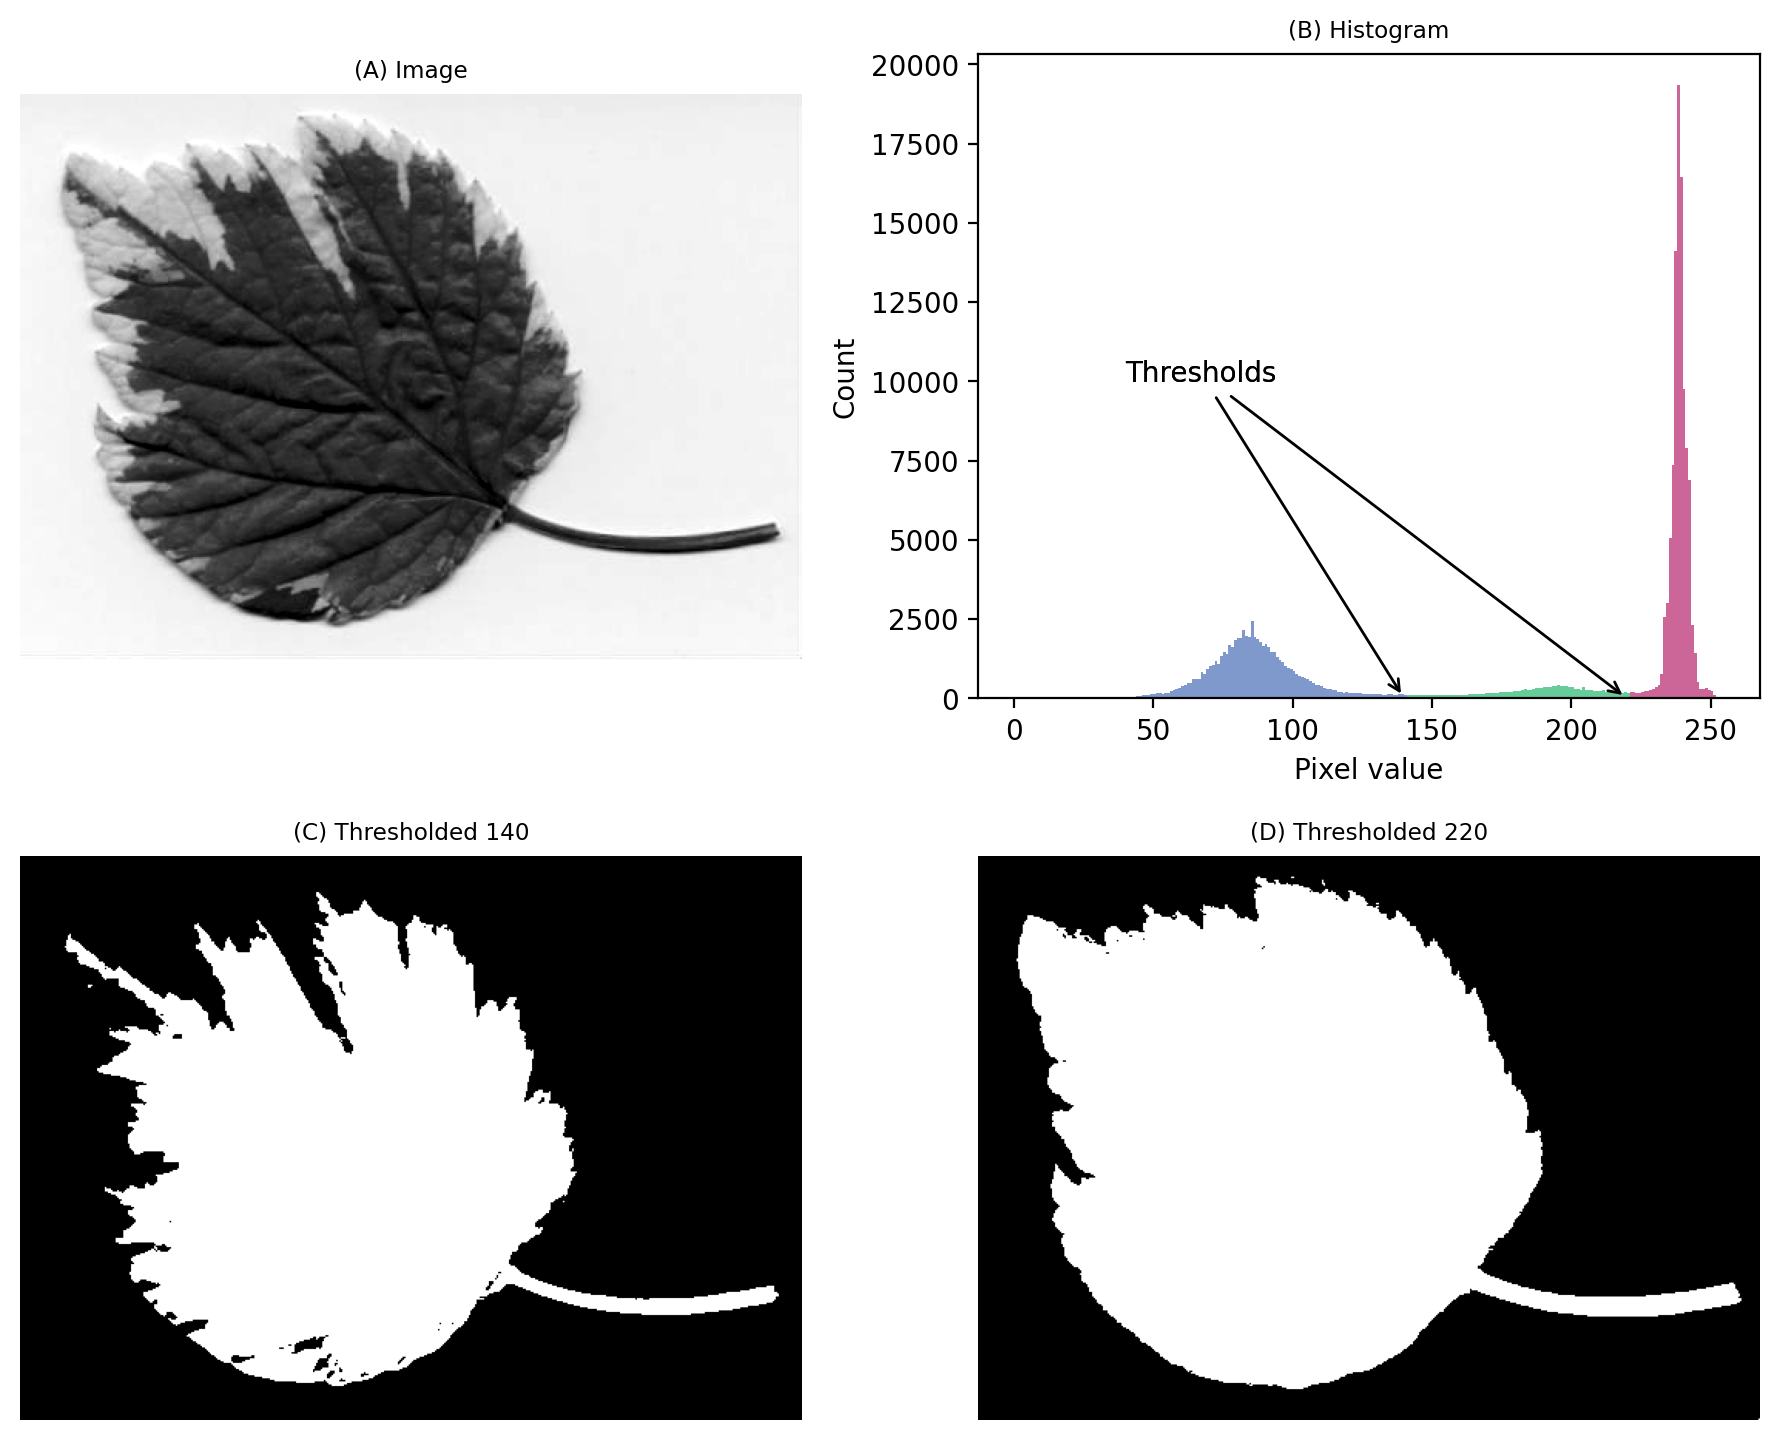

In [7]:
# Load image & set threshold
im = load_leaf()
thresh1 = 140
thresh2 = 220

# Show results
fig = create_figure(figsize=(9, 7.5))
show_image(im, title="(A) Image", clip_percentile=0.5, pos=221)
show_histogram(im[im <= thresh1], title="(B) Histogram", bins=np.arange(0, 256), color=(0.5, 0.6, 0.8), pos=222)
plt.hist(im[(im > thresh1) & (im <= thresh2)].flatten(), bins=np.arange(0, 256), color=(0.4, 0.8, 0.6))
plt.hist(im[im > thresh2].flatten(), bins=np.arange(0, 256), color=(0.8, 0.4, 0.6))
plt.annotate('Thresholds', (thresh1, 0), xytext=(40, 10000), arrowprops=dict(arrowstyle='->'))
plt.annotate('Thresholds', (thresh2, 0), xytext=(40, 10000), arrowprops=dict(arrowstyle='->'))
show_image(im < thresh1, title=f"(C) Thresholded {thresh1}", pos=223)
show_image(im < thresh2, title=f"(D) Thresholded {thresh2}", pos=224)

plt.tight_layout()

glue_fig('fig_thresholds_leaf_histogram', fig)

```{glue:figure} fig_thresholds_leaf_histogram
---
align: center
name: fig-thresholds_leaf_histogram
---
An image where evaluating the histogram suggests two candidate thresholds.
The 'correct' threshold depends upon the desired outcome. Note that here we identify pixels *below* the threshold value, rather than above, because the background is ligher.
```

:::{admonition} Histograms can help us choose thresholds
:class: tip

Histograms can be really useful when choosing threshold values -- but we need to also incorporate knowledge of *why* we are thresholding.
:::

### The importance of the threshold choice

We've seen that histograms can help us identify suitable thresholds, but they don't absolve us of the need to think.
This is particularly evident when objects are not very distinct.
The exact choice of threshold can then be crucial.

{numref}`fig-thresholds_manual` shows an example where the goal is to detect the bright spots (lysosomes).
No single global threshold can give us perfect results, but at first glance many different thresholds can appear to give *somewhat* sensible results.
The histogram gives, at best, a vague hint where a good threshold may lurk.

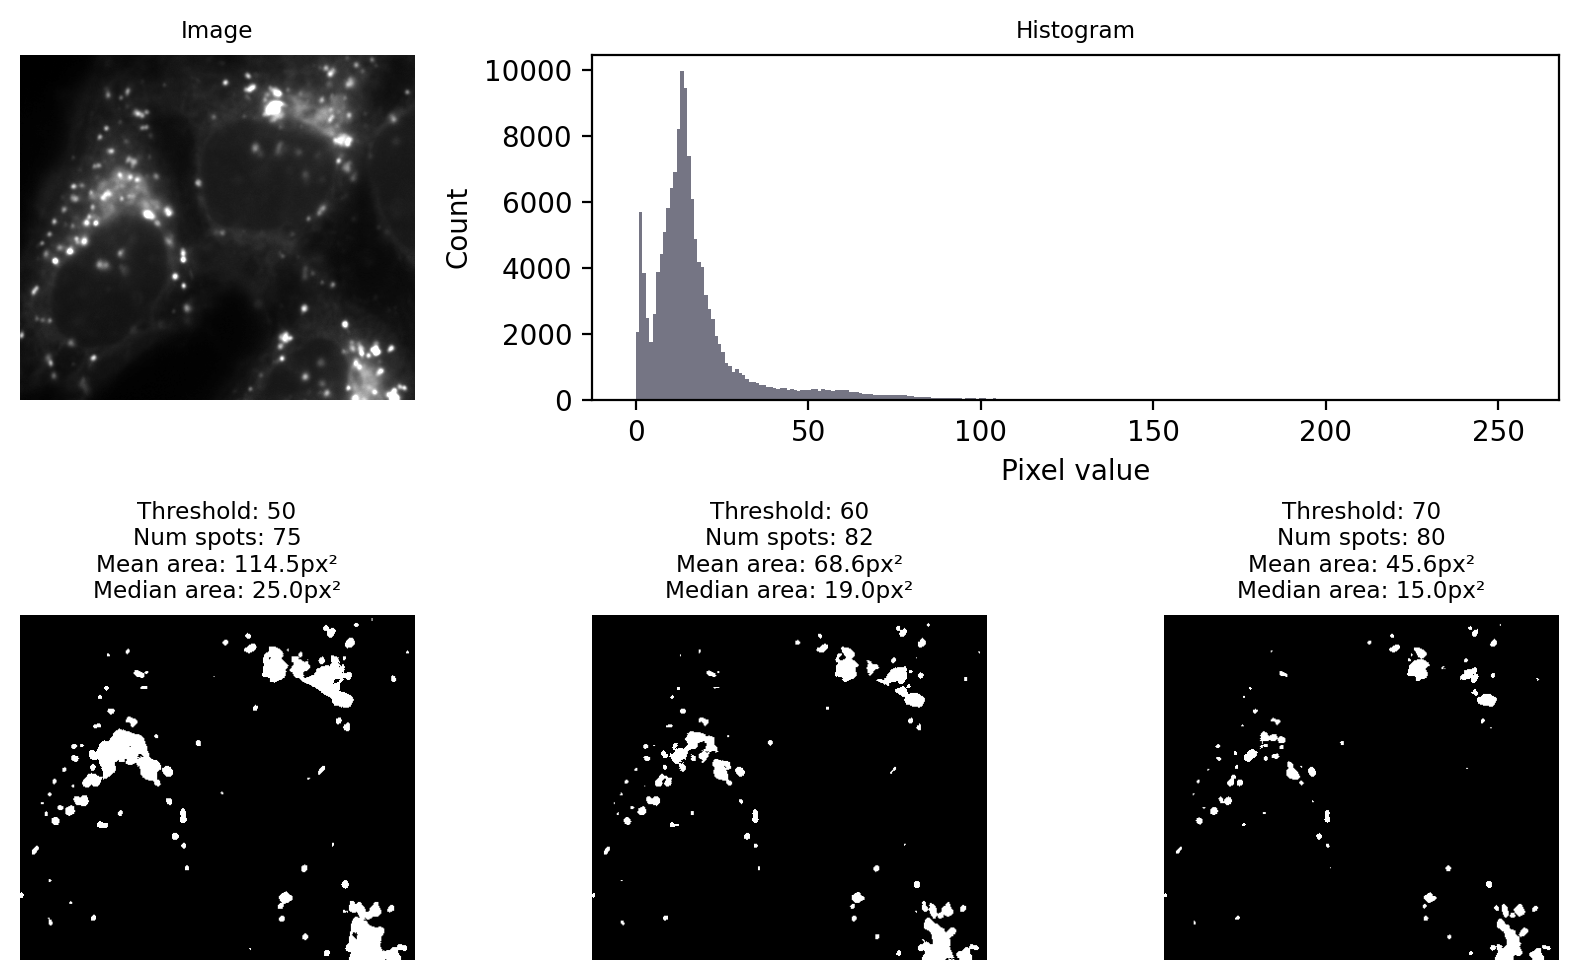

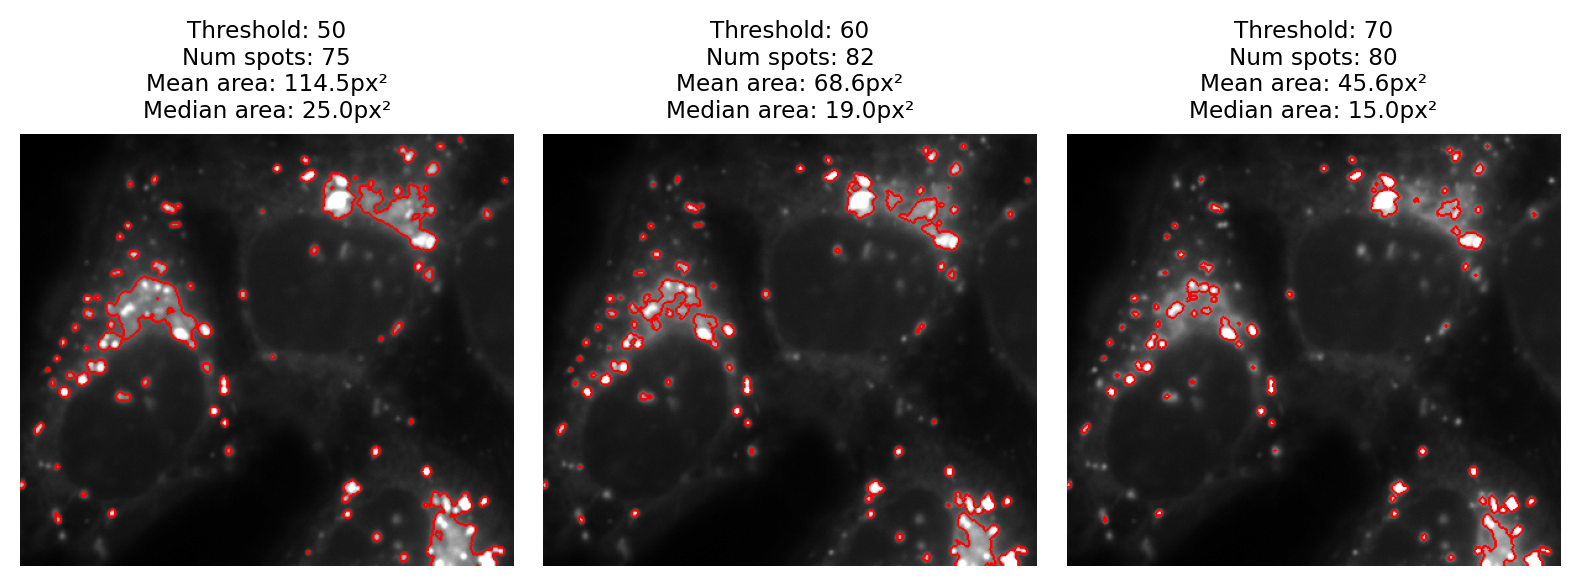

In [8]:
from scipy import ndimage
from myst_nb import glue

# Load image
im = load_image('hela-cells.zip')[50:400, 50:450, 0].astype(np.float32)
# im = im - ndimage.median_filter(im, size=25)
im -= im.min()
im = im / im.max()
im = (im * 255).astype(np.uint8)

# Define thresholds
thresholds = (50, 60, 70)

# Show results
fig = create_figure(figsize=(8, 5))
show_image(im, title="Image", clip_percentile=0.5, pos=231)
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=2)
show_histogram(im, title="Histogram", bins=256)
pos = 234
labeled_images = []
for t in thresholds:
    bw = im > t
    lab, n = ndimage.label(bw)
    hist = np.histogram(lab, bins=range(n+2))[0]
    mean_area = hist[1:].mean()
    median_area = np.median(hist[1:])
    title = f"Threshold: {t}\nNum spots: {n}\nMean area: {mean_area:.1f}px²\nMedian area: {median_area:.1f}px²"
    show_image(bw, title=title, pos=pos)
    # Store image for later
    labeled_images.append((title, lab))
    pos += 1

plt.tight_layout()
plt.show()
glue_fig('fig_thresholds_manual', fig)

# Create a second figure with boundaries
# Create a clipped image for display using mark_boundaries
im2 = im.astype(np.float32) - np.percentile(im, 0.5)
im2 = im2 / np.percentile(im2, 99.5)
im2 = np.clip(im2, 0, 1)

fig2 = create_figure(figsize=(8, 3))
pos = 131
for title, lab in labeled_images:
    show_image(mark_boundaries(im2, lab, mode='thick', color=(1, 0, 0)), title=title, pos=pos)
    pos += 1
plt.tight_layout()
plt.show()
glue_fig('fig_thresholds_manual_overlays', fig2)

```{glue:figure} fig_thresholds_manual
---
align: center
name: fig-thresholds_manual
---
Applying different manually-chosen thresholds to the same image can give quite different results.
```

I would like to convey three main messages from {numref}`fig-thresholds_manual`:

* The **choice of threshold is crucial**, influencing the numbers *and* areas of spots
  * A **threshold that is too low** tends to **make structures bigger & merge some together**
  * A **threshold that is too high** tends to **make structures smaller & miss some**
* Choosing a threshold manually gives a **huge opportunity to introduce bias**
* We should **consider our errors when selecting output metrics**. For example, if we needed to estimate the size of a spot from any of these results then the median is likely to be preferable, because it is less impacted by artificially large spots caused by merging.

A fourth point I would like to make is that **visualization matters too**.
Looking only at the binary images, it is difficult to really evaluate *any* of the results.
It helps enormously to overlay the detected regions on top of the original image ({numref}`fig-thresholds_manual_overlays`).
From this we can see much more clearly that none of the results are terribly good: every threshold we tried misses some spots and merges others.

```{glue:figure} fig_thresholds_manual_overlays
---
align: center
name: fig-thresholds_manual_overlays
---
The binary images of {numref}`fig-thresholds_manual` viewed as overlays instead.
```

:::{admonition} Beware summary plots!
:class: danger

I sometimes sit in lab meetings where people discuss their image analysis results without showing a single image.
I don't approve of this at all.

It's easy to generate summary data with image analysis.
In fact, it's disturbingly easy to generate vastly different -- even conflicting -- summary data by analyzing the same images in different ways.
But, most worryingly of all, one can often concoct a biologically-plausible-sounding story around almost any results.

It's crucial to visualize *what* is being detected and measured in each image, not just a spreadsheet or plot of the results.
This is especially important when applying batch processing to many images at once.
It's tempting to check a few images and then trust the summary spreadsheet for the next 10,000, but I think there is no substitute for visualizing all (or at least a large proportion) of the images themselves.

**For that reason, I would argue that devising an efficient visualization strategy is every bit as important as devising an analysis strategy.**

Image overlays are often a good way to do this: for each image you analyze, create an RGB copy that outlines everything that was detected and measured.
Ideally, this would have brightness and contrast settings defined in such a way that you can see at a glance when something has gone wrong.
You might only look at each image for a fraction of a second through *Windows Explorer* or *Mac Finder*, but that can be enough to spot issues that would otherwise be missed.

:::

In [the last section](sec_thresholding_difficult) we'll see how applying preprocessing steps to the image can allow us to reduce the proportion of spots that are merged or missed.
But first we'll consider how to automate the threshold choice.

## Automated thresholds

We don't want to choose thresholds manually if we can avoid it, because it affords so much room for bias.
On the other hand, there's no always-applicable strategy to determine a threshold automatically; images vary too much.

Nevertheless, there are some widely-used techniques capable of determining reasonable thresholds for many images based upon the histogram.
Each one is based upon some underlying assumptions about the histogram shape or image statistics.
If these assumptions are met, the method often performs well; if not, it may perform well *sometimes* and disastrously at other times.

In this section, we'll look at several of the most common automated thresholding methods using three images.
Each image exhibits a different kind of histogram that is commonly found in bioimages:

* **Bimodal:** with two distinct peaks, corresponding to foreground and background
* **Unimodal:** mostly background noise, with some interesting signal at one end
* **Dominant background:** one large background peak, with a long tail of foreground pixels

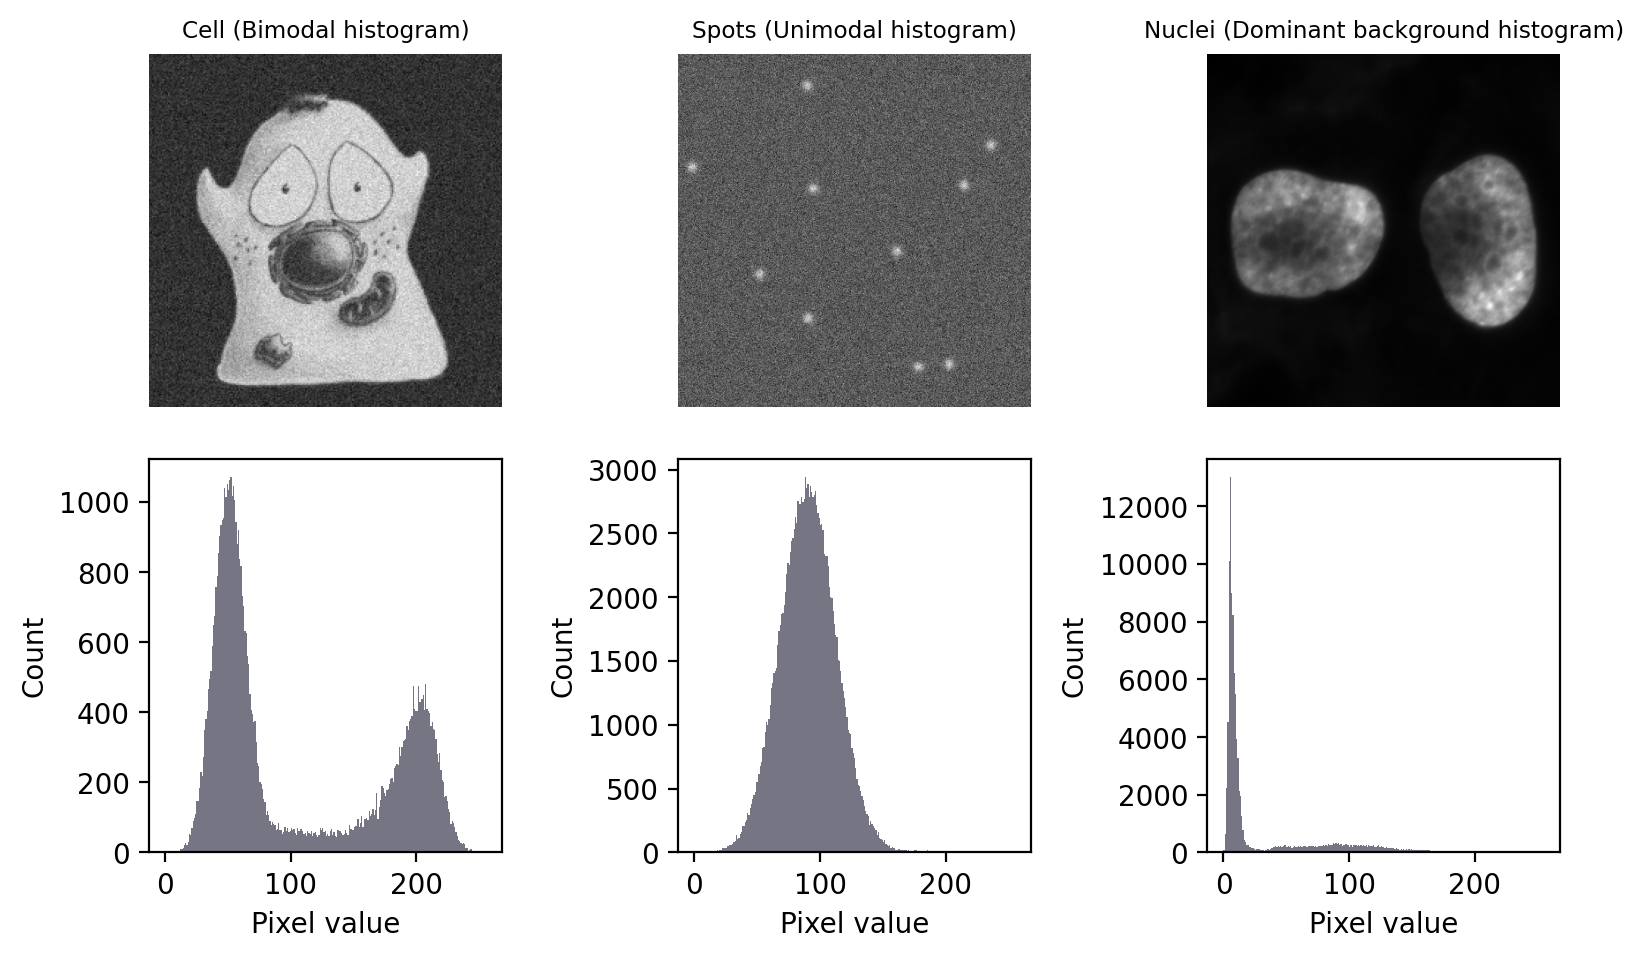

In [9]:
def create_spots(shape=(400, 400), n_spots=10, spot_sigma=4, spot_intensity=5, seed=1024, to_uint8=True):
    im = np.zeros(shape, dtype=np.float32)
    rng = np.random.default_rng(seed)
    rows = rng.integers(0, high=im.shape[0], size=n_spots)
    cols = rng.integers(0, high=im.shape[1], size=n_spots)
    im[rows, cols] = 100
    im = ndimage.gaussian_filter(im, sigma=spot_sigma)
    im = im / im.max() * spot_intensity
    im = im + rng.normal(size=im.shape)
    if to_uint8:
        return convert_to_uint8(im)
    else:
        return im

def load_cell(noise_sigma=None, seed=2048, to_uint8=True):
    im = load_image('happy_cell.tif')[:, 5:-5]
    if noise_sigma:
        rng = np.random.default_rng(seed)
        im = im + rng.normal(scale=noise_sigma, size=im.shape)
    if to_uint8:
        return convert_to_uint8(im)
    else:
        return im

def create_threshold_images():
    im_cell = load_cell(noise_sigma=5)
    im_spots = create_spots()
    im_nuclei = load_nuclei(do_square=True)
    return im_cell, im_spots, im_nuclei

im_cell, im_spots, im_nuclei = create_threshold_images()

fig = create_figure(figsize=(8, 5))
show_image(im_cell, title='Cell (Bimodal histogram)', pos=231)
show_histogram(im_cell, bins=np.arange(0, 256), pos=234)

show_image(im_spots, title='Spots (Unimodal histogram)', pos=232)
show_histogram(im_spots, bins=np.arange(0, 256), pos=235)

show_image(im_nuclei, title='Nuclei (Dominant background histogram)', pos=233)
show_histogram(im_nuclei, bins=np.arange(0, 256), pos=236)

plt.tight_layout()
glue_fig('fig_thresholds_histogram_types', fig)

```{glue:figure} fig_thresholds_histogram_types
---
align: center
name: fig-thresholds_histogram_types
---
Images with three different types of histogram.
```

(sec_thresholds_otsu)=
### Otsu's method

By its nature, global thresholding assumes that there are two classes of pixel in the image -- those that belong to interesting objects, and those that do not -- and pixels in each class have different intensity values [^fn_2].
In principle, if we could identify the pixels for each of the two classes, we could calculate statistics such as the mean and variance (i.e. standard deviation squared) for them both separately.

[^fn_2]: Of course there may be multiple classes for different kinds of objects, and perhaps multiple thresholds would make more sense. There is a variation of Otsu's method for identifying multiple thresholds.

```{margin}
Nobuyuki Otsu (1979). "A threshold selection method from gray-level histograms". *IEEE Trans. Sys. Man. Cyber.* 9 (1): 62–66. https://doi.org/10.1109/TSMC.1979.4310076
```

**Otsu's method**, introduced in 1979, has become an extremely popular approach to determining a threshold.
It's commonly described, somewhat intimidatingly, as *'minimizing the intra-class intensity variance'*.
In essence, calculating a threshold using Otsu's method involves adding the variance of the background pixels to the variance of the foreground pixels, for all possible thresholds.
The threshold that is selected is the one for which the sum of the variances is smallest.

We can think of this as trying to keep the distributions of foreground and background pixels 'compact': two peaks that spread as little as possible.

Otsu's method performs very well on data with a bimodal histogram, with a deep valley in between.
Unfortunately, a lot of microscopy images don't have clearly bimodal histograms, and so the method may not be such a good choice.

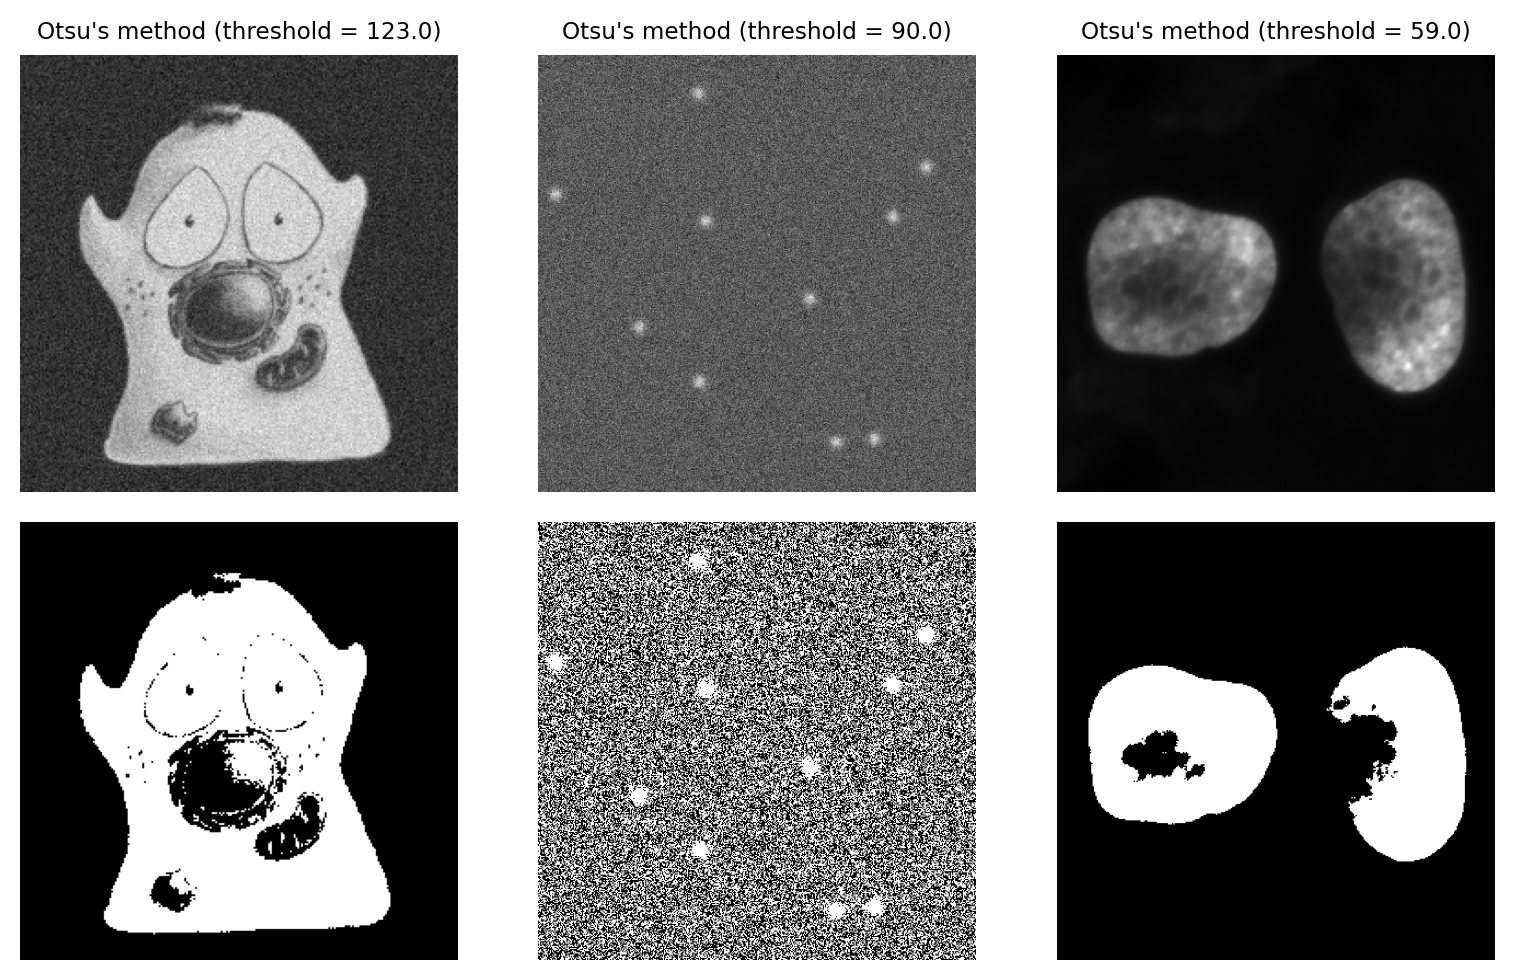

In [10]:
im_cell, im_spots, im_nuclei = create_threshold_images()

fig = create_figure(figsize=(8, 5))
thresh_cell = threshold_otsu(im_cell)
show_image(im_cell, title=f"Otsu's method (threshold = {thresh_cell:.1f})", pos=231)
show_image(im_cell > thresh_cell, pos=234)

thresh_spots = threshold_otsu(im_spots)
show_image(im_spots, title=f"Otsu's method (threshold = {thresh_spots:.1f})", pos=232)
show_image(im_spots > thresh_spots, pos=235)

thresh_nuclei = threshold_otsu(im_nuclei)
show_image(im_nuclei, title=f"Otsu's method (threshold = {thresh_nuclei:.1f})", pos=233)
show_image(im_nuclei > thresh_nuclei, pos=236)

plt.tight_layout()
glue_fig('fig_thresholds_method_otsu', fig)

```{glue:figure} fig_thresholds_method_otsu
---
align: center
name: fig-thresholds_method_otsu
---
Thresholding using Otsu's method. This performs best on the cell image with a bimodal histogram. For the spots image, there is no separation between peaks to find; as a result, approximately half the pixels are identified as foreground. The method also performs quite poorly for the nucleus image, despite this previously being identified as an 'easier' image for thresholding.
```

### Minimum method

The **Minimum method** provides an alternative threshold that also assumes a bimodal histogram.

The starting point is the image histogram.
As can be seen in {numref}`fig-thresholds_histogram_types`, the counts tend to be somewhat 'noisy' with lots of tiny spurious peaks.
The Minimum method operates by smoothing the histogram, replacing each count value with the average of itself and the neighboring counts.
By repeating this process, eventually the spurious peaks are removed until (hopefully) precisely two peaks remain.
The threshold is then the location of the deepest point in the valley between those peaks.

The result of this process is illustrated in {numref}`fig-thresholds_method_minimum`.

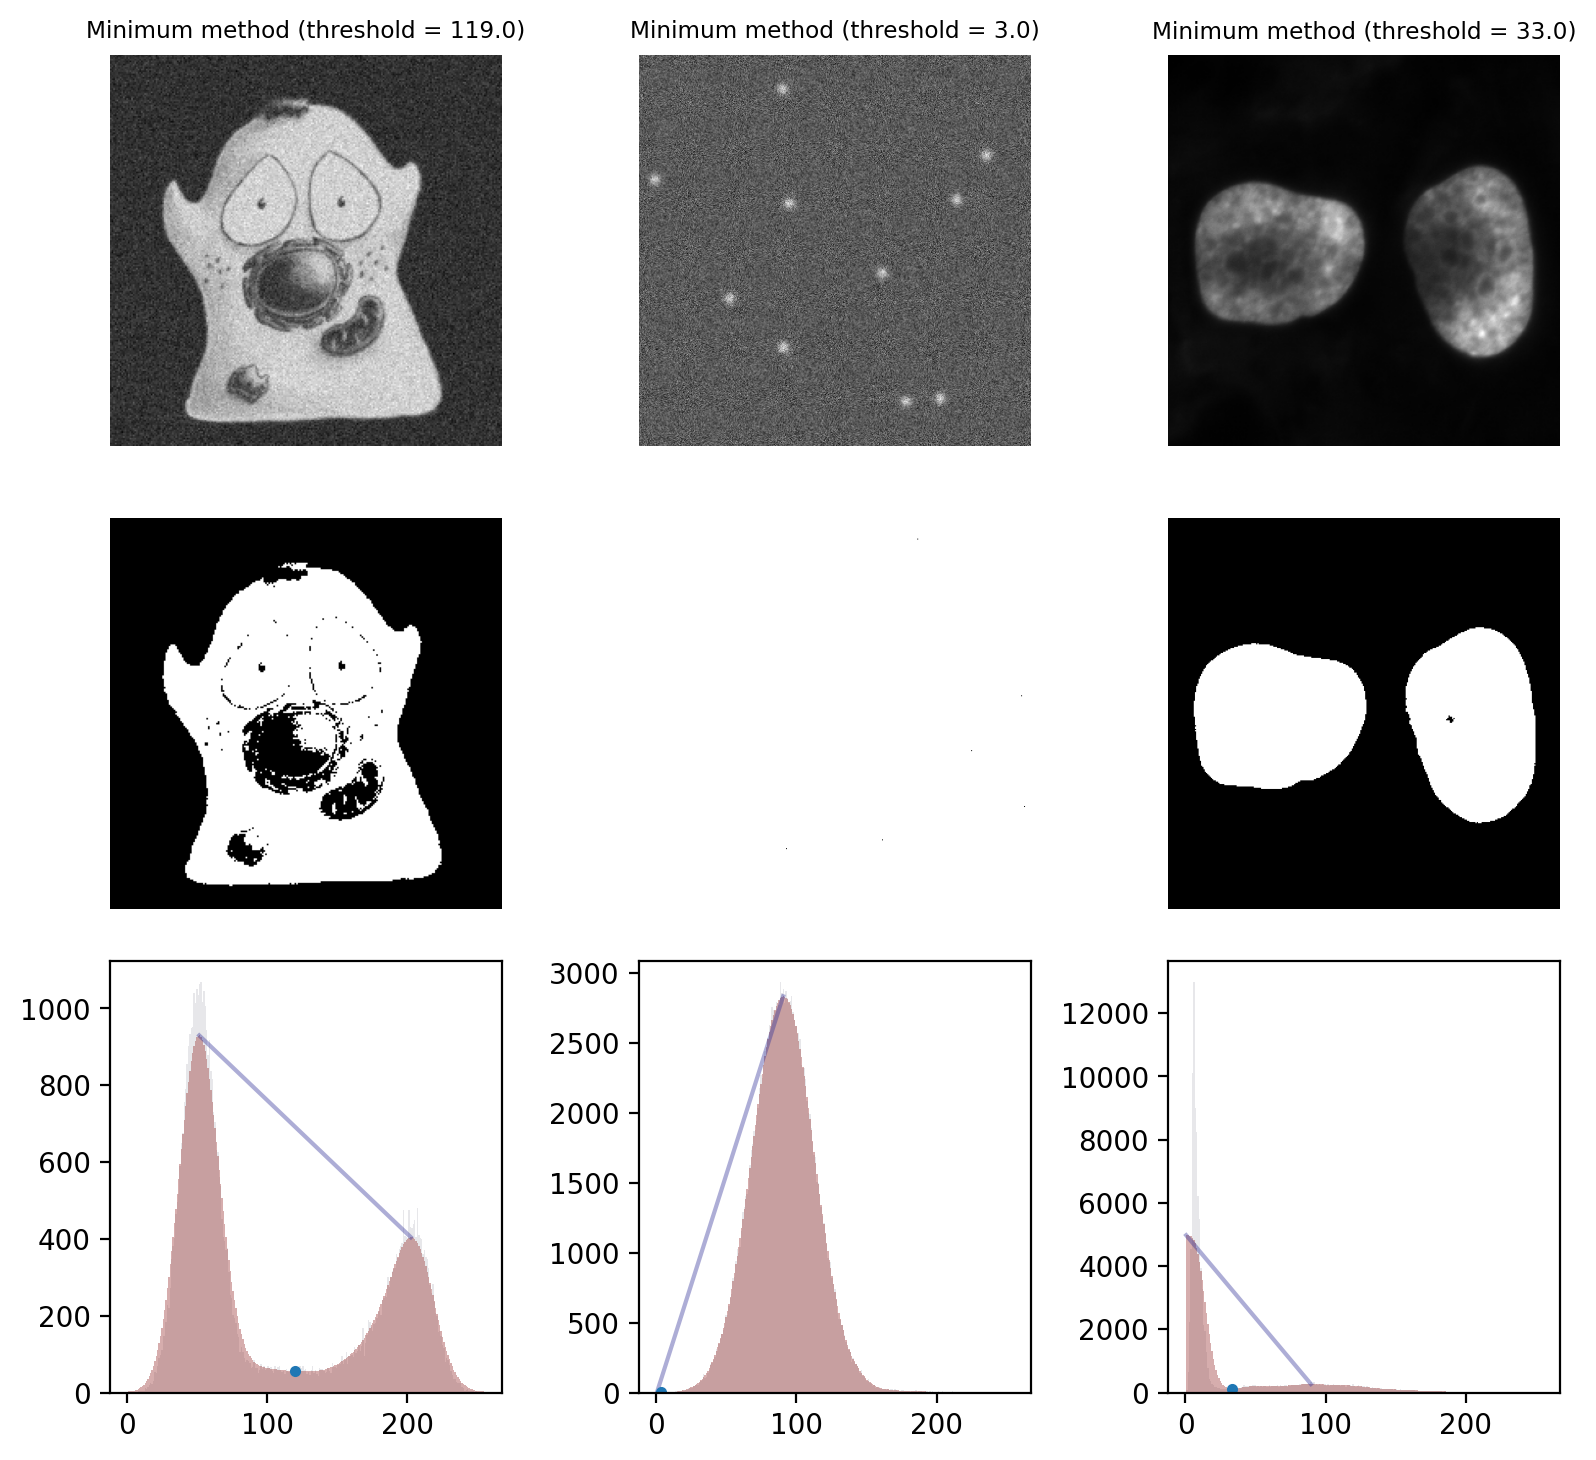

In [11]:
def plot_minimum_threshold(im, bins, thresh, pos=None, max_iters=100):
    if pos:
        plt.subplot(pos)

    def find_local_maxima_idx(hist):
        # This code is taken from scikit-image because it is not publicly accessible
        # https://github.com/scikit-image/scikit-image/blob/v0.19.0/skimage/filters/thresholding.py#L821

        # We can't use scipy.signal.argrelmax
        # as it fails on plateaus
        maximum_idxs = list()
        direction = 1

        for i in range(hist.shape[0] - 1):
            if direction > 0:
                if hist[i + 1] < hist[i]:
                    direction = -1
                    maximum_idxs.append(i)
            else:
                if hist[i + 1] > hist[i]:
                    direction = 1

        return maximum_idxs

    # Create a histogram with bin centers
    hist, bin_edges = np.histogram(im.ravel(), bins=bins)
    hist = hist.astype(np.float64)
    centers = (bin_edges[1:] + bin_edges[:-1])/2.0
    smooth_hist = hist.copy()

    # Smooth histogram until there are <=2 peaks
    for ii in range(max_iters):
        smooth_hist = ndimage.uniform_filter1d(smooth_hist, 3)
        max_inds = find_local_maxima_idx(smooth_hist)
        if len(max_inds) < 3:
            break

    # Check this worked
    if len(max_inds) != 2:
        raise RuntimeError('Unable to find 2 maxima in smoothed histogram!')

    plt.hist(centers, bins=len(hist), weights=hist, color=(0.1, 0.1, 0.2, 0.1))
    plt.hist(centers, bins=len(smooth_hist), weights=smooth_hist, color=(0.6, 0.2, 0.2, 0.4))
    plt.plot(centers[max_inds], smooth_hist[max_inds], color=(0.2, 0.2, 0.6, 0.4))
    plt.plot(centers[thresh], smooth_hist[thresh], marker='.')



from skimage.filters import threshold_minimum

im_cell, im_spots, im_nuclei = create_threshold_images()

fig = create_figure(figsize=(8, 7.5))
thresh_cell = threshold_minimum(im_cell)
show_image(im_cell, title=f"Minimum method (threshold = {thresh_cell:.1f})", pos=331)
show_image(im_cell > thresh_cell, pos=334)
plot_minimum_threshold(im_cell, bins=np.arange(256), thresh=thresh_cell, pos=337)

thresh_spots = threshold_minimum(im_spots)
show_image(im_spots, title=f"Minimum method (threshold = {thresh_spots:.1f})", pos=332)
show_image(im_spots > thresh_spots, pos=335)
plot_minimum_threshold(im_spots, bins=np.arange(256), thresh=thresh_spots, pos=338)

thresh_nuclei = threshold_minimum(im_nuclei)
show_image(im_nuclei, title=f"Minimum method (threshold = {thresh_nuclei:.1f})", pos=333)
show_image(im_nuclei > thresh_nuclei, pos=336)
plot_minimum_threshold(im_nuclei, bins=np.arange(256), thresh=thresh_nuclei, pos=339)

plt.tight_layout()
glue_fig('fig_thresholds_method_minimum', fig)

```{glue:figure} fig_thresholds_method_minimum
---
align: center
name: fig-thresholds_method_minimum
---
Thresholding using the Minimum method. The smoothed histograms used in the calculation are shown in red, with the original histograms shown (faintly) in gray. A line connecting the two final peaks is also included, and the threshold marked with a dot. <br/>
This works well on the cells image and quite well on the nuclei image. However it fails badly on the spots image, where almost everything is detected as foreground. This is a case where the method converges (due to the image being noisy, so having lots of small peaks in the histogram) even though we might prefer it had not.
```

One 'feature' of the Minimum method is that *it is not guaranteed to converge*.
It is entirely possible that no amount of smoothing will result in a histogram with 2 peaks: perhaps there is only 1 peak, or none at all if all pixels are just a constant value.

This could potentially be an advantage: it may be better to return no threshold than to return a really bad one.
However, in most real images we cannot count on the method not converging: it often *does* converge, even if it does not necessarily converge to any desirable value.

(sec_thresholds_triangle)=
### Triangle method

The 'triangle method' is a popular approach to determining a threshold that works especially well in images where there is one dominant background peak, and the ideal threshold should be at the base of that peak.

The general idea is that a a line is drawn from the peak of the histogram to the last bin that contains any pixels.
Then a perpendicular line is plotted to the histogram itself, and the distance to the histogram maximized.
The direction of the line depends upon whether the peak is toward the left or the right of the histogram; all counts on the other side are ignored.

The width and height of the histogram are normalized to deal with the fact that pixel values and intensity counts are in completely different units, and therefore in completely different scales.

The explanation is confusing, but hopefully {numref}`fig-thresholds_method_triangle` depicts it more clearly -- and provides an intuition for when and why it might be appropriate.

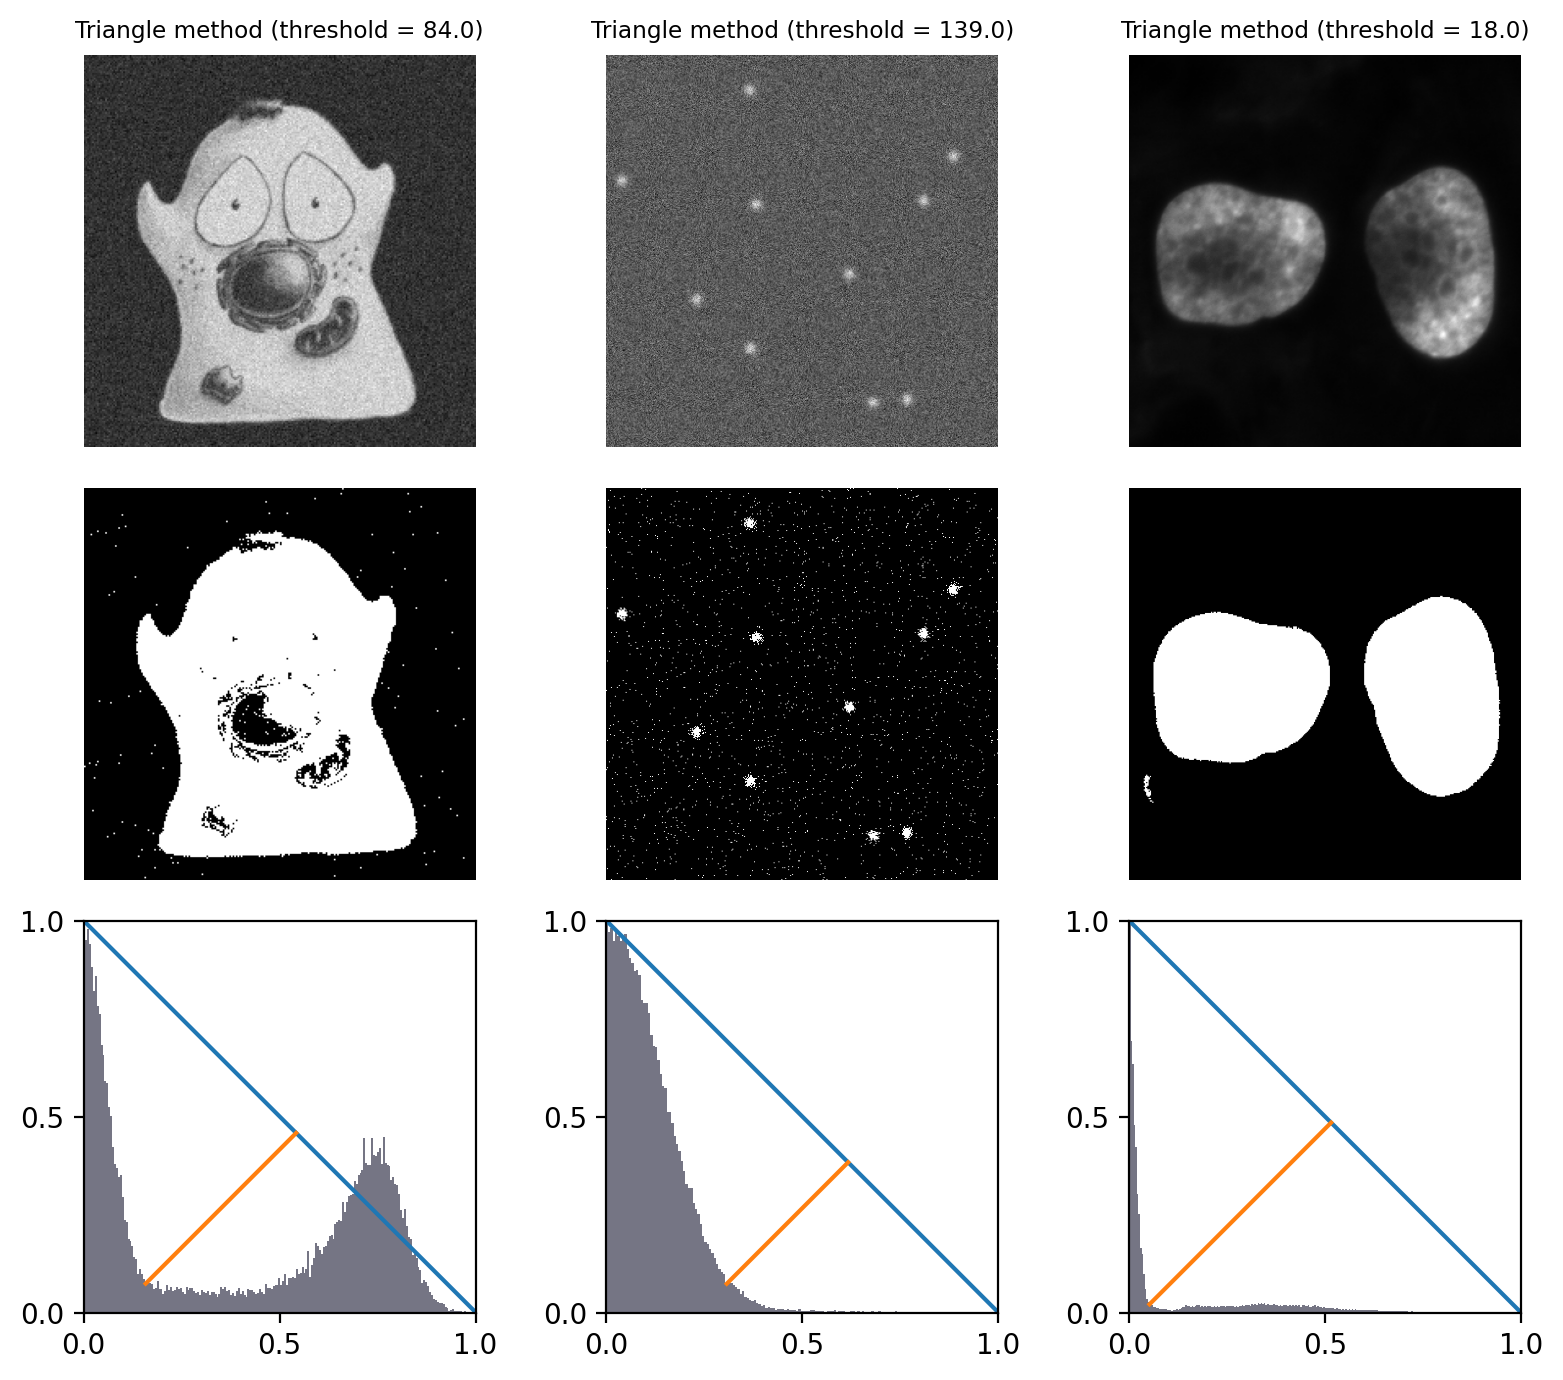

In [12]:
from skimage.filters import threshold_triangle

im_cell, im_spots, im_nuclei = create_threshold_images()

bins = np.arange(0, 256)

def plot_triangle_threshold(im, bins, thresh, pos=None):
    if pos:
        plt.subplot(pos)

    # Create a histogram, identify peak and normalize counts between 0 and 1
    # Note: here we assume the peak is always to the left and we threshold to the right!
    # The proper triangle threshold flips sometimes
    hist, bin_edges = np.histogram(im.ravel(), bins=bins)
    peak_ind = np.argmax(hist)
    peak_height = hist[peak_ind]
    hist = hist / peak_height

    # Identify bin centers
    # Find last bin with non-zero count
    centers = (bin_edges[1:] + bin_edges[:-1])/2.0
    ind_low, ind_high = np.where(hist > 0)[0][[0, -1]]    

    # Shift bin centers according to peak (simplified plotting)
    centers = centers - centers[peak_ind]

    # Compute 'width' of the triangle (base length)
    # Normalize centers so width becomes 1
    width = (centers[ind_high] - centers[peak_ind])
    centers = centers / width

    # Plot histogram with new values
    plt.hist(centers, bins=len(hist), weights=hist, color=(0.1, 0.1, 0.2, 0.6))

    # Plot from peak to base
    x1 = centers[peak_ind]
    y1 = hist[peak_ind]
    x2 = centers[-1]
    y2 = hist[-1]
    plt.plot([x1, x2], [y1, y2])

    # Plot from threshold to peak line
    x3 = centers[int(thresh)]
    y3 = hist[int(thresh)]
    n = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    x4 = x3 + (y2 - y1) / n
    y4 = y3 - (x2 - x1) / n
    # Find intersection
    # Thank you, wikipedia
    # https://en.wikipedia.org/wiki/Line–line_intersection#Given_two_points_on_each_line
    D = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
    px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))/D
    py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))/D
    plt.plot([x3, px], [y3, py])

    # Setup display
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xticks([0, 0.5, 1.0])
    plt.yticks([0, 0.5, 1.0])
    plt.gca().set_aspect('equal')


fig = create_figure(figsize=(8, 7))
thresh_cell = threshold_triangle(im_cell)

show_image(im_cell, title=f"Triangle method (threshold = {thresh_cell:.1f})", pos=331)
show_image(im_cell > thresh_cell, pos=334)
plot_triangle_threshold(im_cell, bins=bins, thresh=thresh_cell, pos=337)

thresh_spots = threshold_triangle(im_spots)
show_image(im_spots, title=f"Triangle method (threshold = {thresh_spots:.1f})", pos=332)
show_image(im_spots > thresh_spots, pos=335)
plot_triangle_threshold(im_spots, bins=bins, thresh=thresh_spots, pos=338)

thresh_nuclei = threshold_triangle(im_nuclei)
show_image(im_nuclei, title=f"Triangle method (threshold = {thresh_nuclei:.1f})", pos=333)
show_image(im_nuclei > thresh_nuclei, pos=336)
plot_triangle_threshold(im_nuclei, bins=bins, thresh=thresh_nuclei, pos=339)

plt.tight_layout()
glue_fig('fig_thresholds_method_triangle', fig)

```{glue:figure} fig_thresholds_method_triangle
---
align: center
name: fig-thresholds_method_triangle
---
Thresholding using the Triangle method. Because all example histograms have a dominant peak, this performs quite well in all cases -- although tends to detect more foreground pixels in the cell image than other methods (because the threshold is at the base of the peak rather than between the two modes). <br/>
The histograms depict the triangles that give the method its name.
They have been normalized and truncated to include only the relevant part.
```

### Mean method

An alternative simple approach is to skip the histogram altogether, and just use the mean of all pixel values.

This can actually give quite good reasons on many real-world images -- although this may be more through luck than design.
It's not a method I typically use myself.

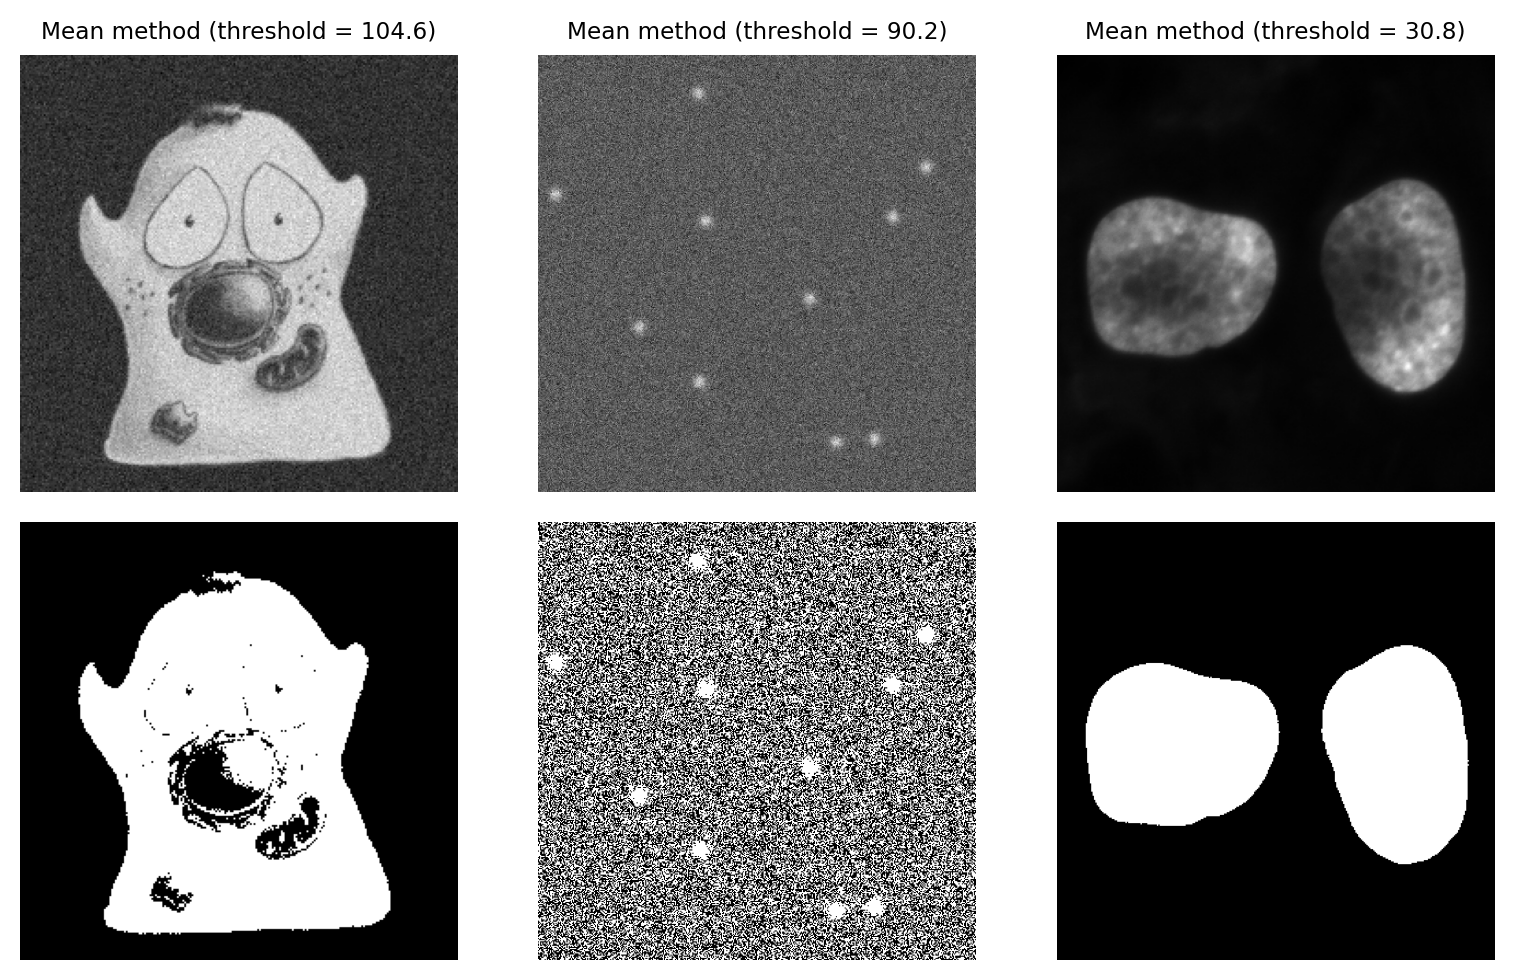

In [13]:
def threshold_mean(im: np.ndarray):
    return im.mean()

im_cell, im_spots, im_nuclei = create_threshold_images()

fig = create_figure(figsize=(8, 5))
thresh_cell = threshold_mean(im_cell)
show_image(im_cell, title=f"Mean method (threshold = {thresh_cell:.1f})", pos=231)
show_image(im_cell > thresh_cell, pos=234)

thresh_spots = threshold_mean(im_spots)
show_image(im_spots, title=f"Mean method (threshold = {thresh_spots:.1f})", pos=232)
show_image(im_spots > thresh_spots, pos=235)

thresh_nuclei = threshold_mean(im_nuclei)
show_image(im_nuclei, title=f"Mean method (threshold = {thresh_nuclei:.1f})", pos=233)
show_image(im_nuclei > thresh_nuclei, pos=236)

plt.tight_layout()
glue_fig('fig_thresholds_method_mean', fig)

```{glue:figure} fig_thresholds_method_mean
---
align: center
name: fig-thresholds_method_mean
---
Thresholding using the Mean method.
```

### Mean & Standard deviation

We can add a bit more to the *Mean method* by incorporating the standard deviation, scaled by a constant.
The threshold becomes *mean + k x standard.deviation*, where we can adjust *k* based upon our attitude towards sensitivity vs. specificity.

The main advantage of this approach is that it should not fail catastropically in cases where we have an image that is mostly just noise (assuming *k* is large enough), unlike methods that require a bimodal histogram.
However the disadvantage is that it is not robust: the threshold can be pulled higher or lower by outliers, or by foreground values being very different from background values.

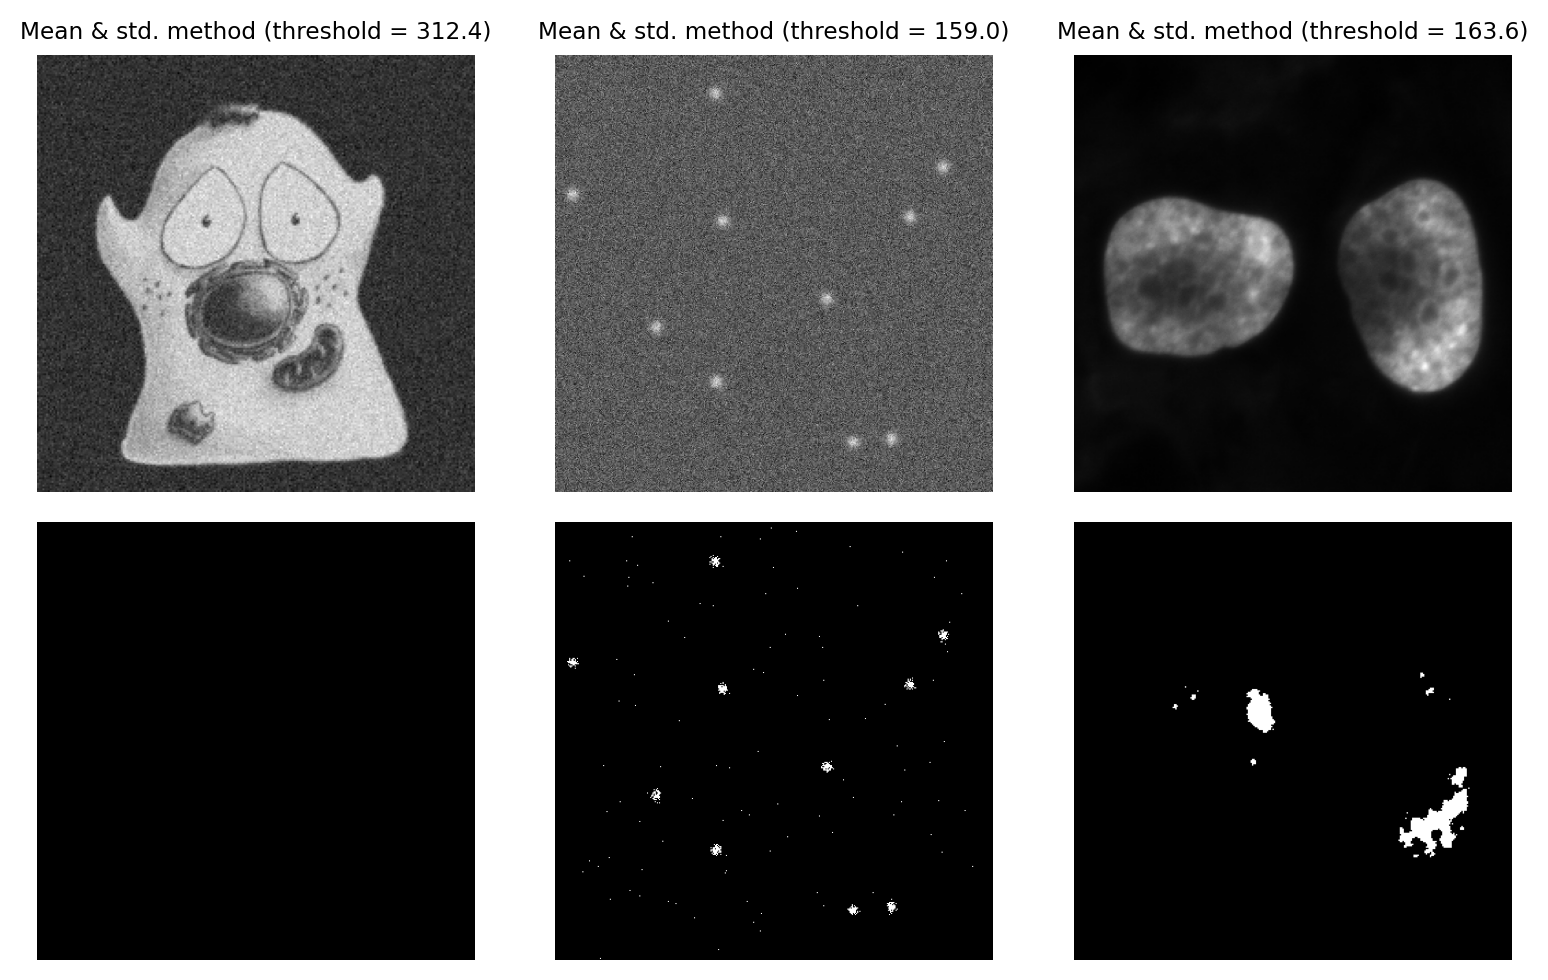

In [14]:
def threshold_mean_std(im: np.ndarray, k=4):
    return im.mean() + k * im.std()

im_cell, im_spots, im_nuclei = create_threshold_images()

fig = create_figure(figsize=(8, 5))
k = 3
thresh_cell = threshold_mean_std(im_cell, k=k)
show_image(im_cell, title=f"Mean & std. method (threshold = {thresh_cell:.1f})", pos=231)
show_image(im_cell > thresh_cell, pos=234)

thresh_spots = threshold_mean_std(im_spots, k=k)
show_image(im_spots, title=f"Mean & std. method (threshold = {thresh_spots:.1f})", pos=232)
show_image(im_spots > thresh_spots, pos=235)

thresh_nuclei = threshold_mean_std(im_nuclei, k=k)
show_image(im_nuclei, title=f"Mean & std. method (threshold = {thresh_nuclei:.1f})", pos=233)
show_image(im_nuclei > thresh_nuclei, pos=236)

plt.tight_layout()
glue_fig('fig_thresholds_method_mean_std', fig)

```{glue:figure} fig_thresholds_method_mean_std
---
align: center
name: fig-thresholds_method_mean_std
---
Thresholding using the Mean + k x std.dev. method, with k = 3.
```

### Median & Median Absolute Deviation

A more robust alternative to using the mean and standard deviation is to use the **median and median absolute deviation (MAD)** to determine a threshold.

If the pixel values of an image were to be sorted, the **median** is the value that would be in the middle.
The **MAD** is calculated as follows:

1. Subtract the median from all pixels
2. Compute the absolute value of the result of (1) (i.e. flip the sign of negative values, so that all are positive)
3. Compute the median of the result of (2)

An intriguingly useful property of the MAD is that it can be scaled by 1.482 to resemble a (more robust) standard deviation.
The [Wikipedia article](https://en.wikipedia.org/wiki/Median_absolute_deviation) explains this in more detail.

Typically, we would use the *median + k x MAD x 1.482*, where we can adjust *k* as if it was used to scale a standard deviation.
This is helpful because standard deviations are easier for (most of) us to tune.

Using the MAD to define a threshold remains fairly uncommon, but I personally like the method a lot when working with very noisy fluorescence images.
The three main requirements for this method to work are:

* Most of the image should be background, and noisy (a completely constant background will give a MAD of 0, and a bad threshold)
* The noise should (more or less) follow a normal distribution
* The image shouldn't be too large, because calculating the median exactly is slow

The last point is not always an issue: we can calculate the median much more quickly if we use a histogram, although we may lose some precision due to the binning required when building the histogram.

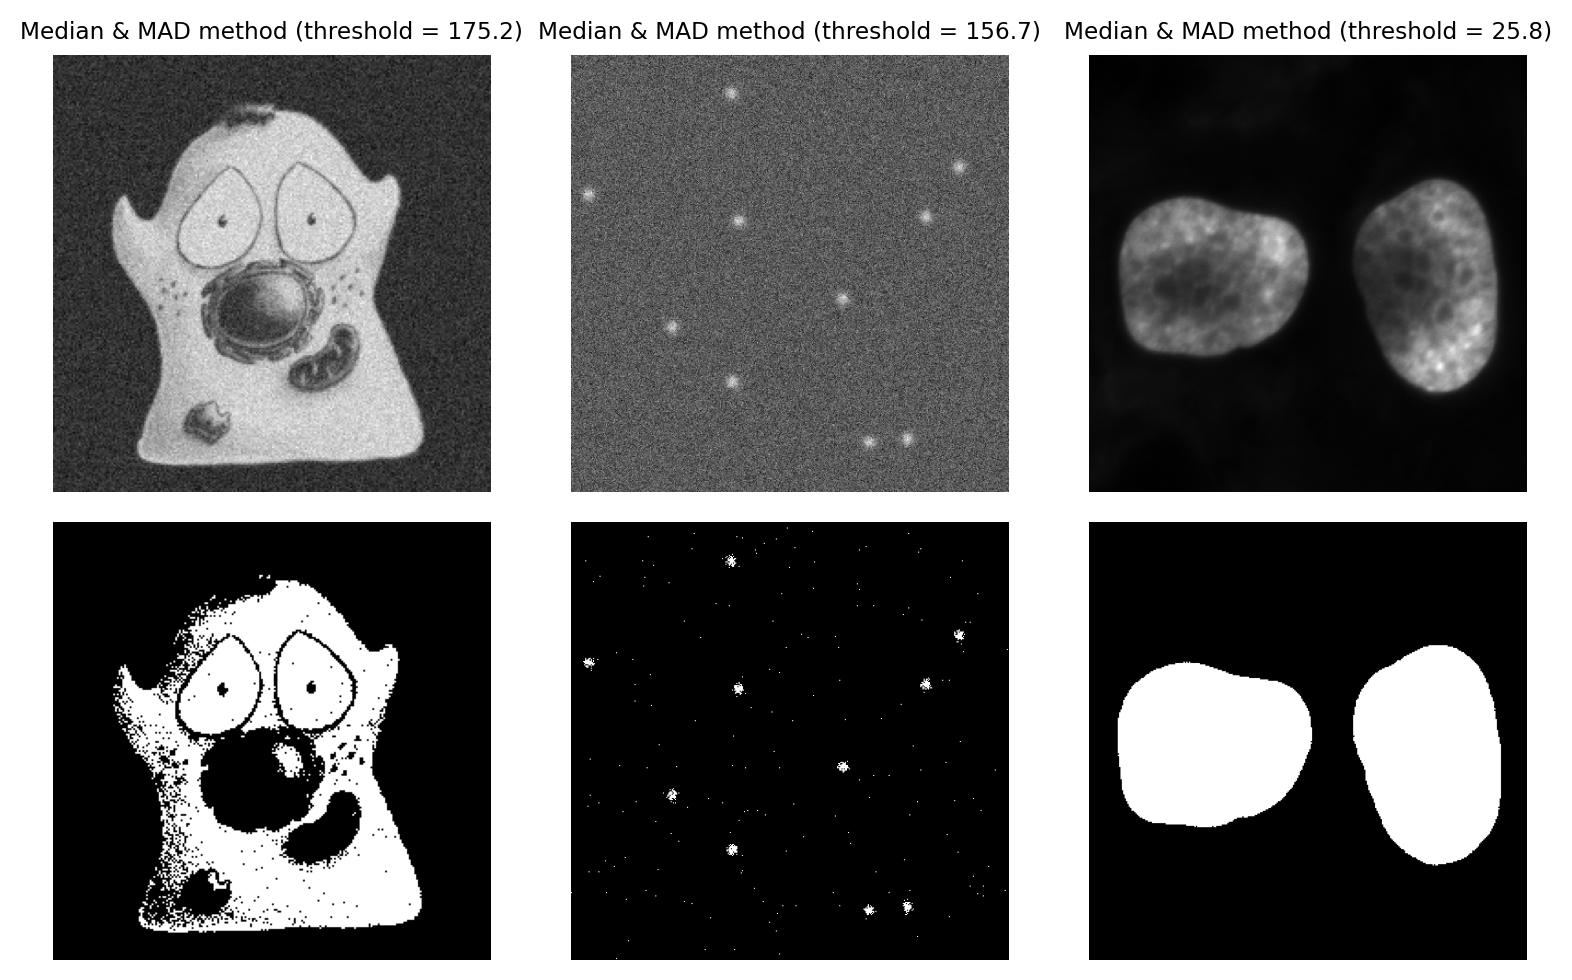

In [15]:
def threshold_mad(im: np.ndarray, k=4):
    med = np.median(im)
    mad = np.median(np.abs(im.astype(np.float32) - med))
    return med + mad * k * 1.4826

im_cell, im_spots, im_nuclei = create_threshold_images()

fig = create_figure(figsize=(8, 5))
k = 3
thresh_cell = threshold_mad(im_cell, k=k)
show_image(im_cell, title=f"Median & MAD method (threshold = {thresh_cell:.1f})", pos=231)
show_image(im_cell > thresh_cell, pos=234)

thresh_spots = threshold_mad(im_spots, k=k)
show_image(im_spots, title=f"Median & MAD method (threshold = {thresh_spots:.1f})", pos=232)
show_image(im_spots > thresh_spots, pos=235)

thresh_nuclei = threshold_mad(im_nuclei, k=k)
show_image(im_nuclei, title=f"Median & MAD method (threshold = {thresh_nuclei:.1f})", pos=233)
show_image(im_nuclei > thresh_nuclei, pos=236)

plt.tight_layout()
glue_fig('fig_thresholds_method_mad', fig)

```{glue:figure} fig_thresholds_method_mad
---
align: center
name: fig-thresholds_method_mad
---
Thresholding using the MAD method, with *k = 3*. This is a strong candiate to be my preferred method for the 'spots' image, because it is effective when looking for small signals buried in noise.
```

:::{admonition} Clipping confounds automated thresholds
:class: danger

If the data is [clipped](chap_bit_depths), then the statistics of the pixel values and shape of the image histogram are changed.
This means that the theory underlying why an automated threshold should work might well no longer apply.

*This is another reason why clipping should always be avoided!*
:::


:::{admonition} Are automated thresholds less biased?

I sometimes see the use of automated thresholding methods justified because they are *'less biased than manual thresholds'*.

I am unconvinced.

I *do* agree that automated thresholds are strongly preferable to subjectively picking a threshold by eye -- but only if they can be shown to work reliably for a particular dataset.
A bad automated threshold can easily introduce a systematic bias that is much worse than manually setting a threshold for each image.
:::

(sec_thresholding_difficult)=
## Thresholding difficult data

Applying global thresholds is all well and good in easy images for which a threshold clearly exists, but in practice things are rarely so straightforward – and often no threshold, manual or automatic, produces useable results.
This section anticipates the next chapter on filters by showing that, with some extra processing, thresholding can be redeemed even if it initially seems to perform badly.

### Thresholding noisy data

Noise is one problem that affects thresholds, especially in live cell imaging.

The top half of {numref}`fig-thresholds_noisy` reproduces the nuclei from {numref}`fig-thresholds_nuclei_histogram` but with extra noise added to simulate less than ideal imaging conditions.
Although the nuclei are still clearly visible in the image (A), the two classes of pixels (which were previously easy to separate) have now been merged together in the histogram (B).
The triangle threshold method, which had performed well before, now gives less attractive results \(C), because the noise has caused the ranges of background and nuclei pixels to overlap.

*However,* if we apply a Gaussian filter to smooth the image, a lot of the random noise is reduced (see {ref}`chap_filters`).
This results in a histogram dramatically more similar to that in the original, (almost) noise-free image, and the threshold is again quite successful (F).

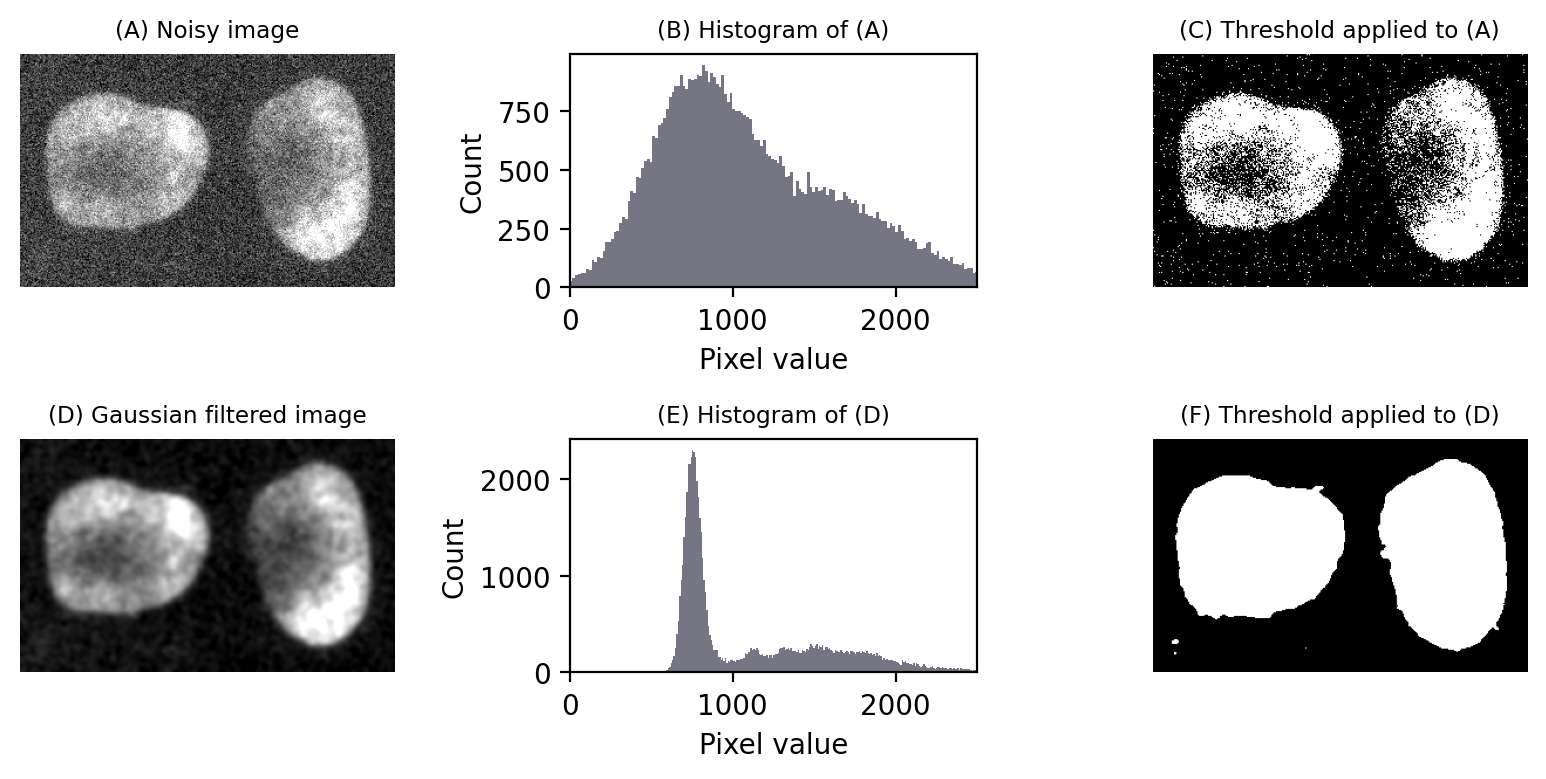

In [16]:
fig = create_figure(figsize=(8, 4))

from scipy.ndimage import gaussian_filter

# Read image
im = load_nuclei(to_uint8=False).astype(np.float32)

# Add noise (and a constant to avoid clipping)
rng = np.random.default_rng(100)
im_noisy = im + 500 + rng.normal(size=im.shape) * 300

# Apply triangle threshold
bw_noisy_triangle = im_noisy > threshold_triangle(im_noisy)

# Filter to reduce noise, then threshold again
sigma = 2.0
im_filtered = gaussian_filter(im_noisy, sigma)

# Apply triangle threshold
bw_filtered_triangle = im_filtered > threshold_triangle(im_filtered)

show_image(im_noisy, title="(A) Noisy image", clip_percentile=2, pos=231)
show_histogram(im_noisy.flatten(), bins=256, title="(B) Histogram of (A)", pos=232)
plt.xlim([0, 2500])
show_image(bw_noisy_triangle, title="(C) Threshold applied to (A)", pos=233)

show_image(im_filtered, title="(D) Gaussian filtered image", clip_percentile=2, pos=234)
show_histogram(im_filtered, bins=256, title="(E) Histogram of (D)", pos=235)
plt.xlim([0, 2500])
show_image(bw_filtered_triangle, title="(F) Threshold applied to (D)", pos=236)

plt.tight_layout()

glue_fig('fig_thresholds_noisy', fig)

```{glue:figure} fig_thresholds_noisy
---
align: center
name: fig-thresholds_noisy
---
Noise can affect thresholding. After the addition of simulated noise to the image in {numref}`fig-thresholds_nuclei_histogram`, the distinction between nuclei and non-nuclei pixels is much harder to identify in the histogram (B). Any threshold would result in a large number of incorrectly-identified pixels. However, applying a Gaussian filter (here, $\sigma = 2$) to reduce noise can dramatically improve the situation (E). Thresholds in \(C) and (F) were computed using the triangle method.
```


### Local thresholding

Another common problem is that the structures that should be detected appear on top of a background that itself varies in brightness.
This was the reason no threshold performed very well in {numref}`fig-thresholds_manual`.

Ideally, we would like to apply a threshold that varies relative to the local background.

```{margin}
W. Niblack, An introduction to Digital Image Processing, Prentice-Hall, 1986.
```

There are a variety of **local thresholding** methods available, many of which are variations on the **Niblack method**.
This calculates the mean and standard deviation of pixels *in a local window around each pixel*, for example a square of 25 x 25 pixels.

A separate threshold is then generated for every pixel,defined as *local_mean - k x local_std.dev*.
Note the sign: *-k* is used, because the original definition was focussed on recognizing dark text on a light background, but *k* itself can be a negative number if needed.

An example is shown in {numref}`fig-thresholds_local_niblack`.

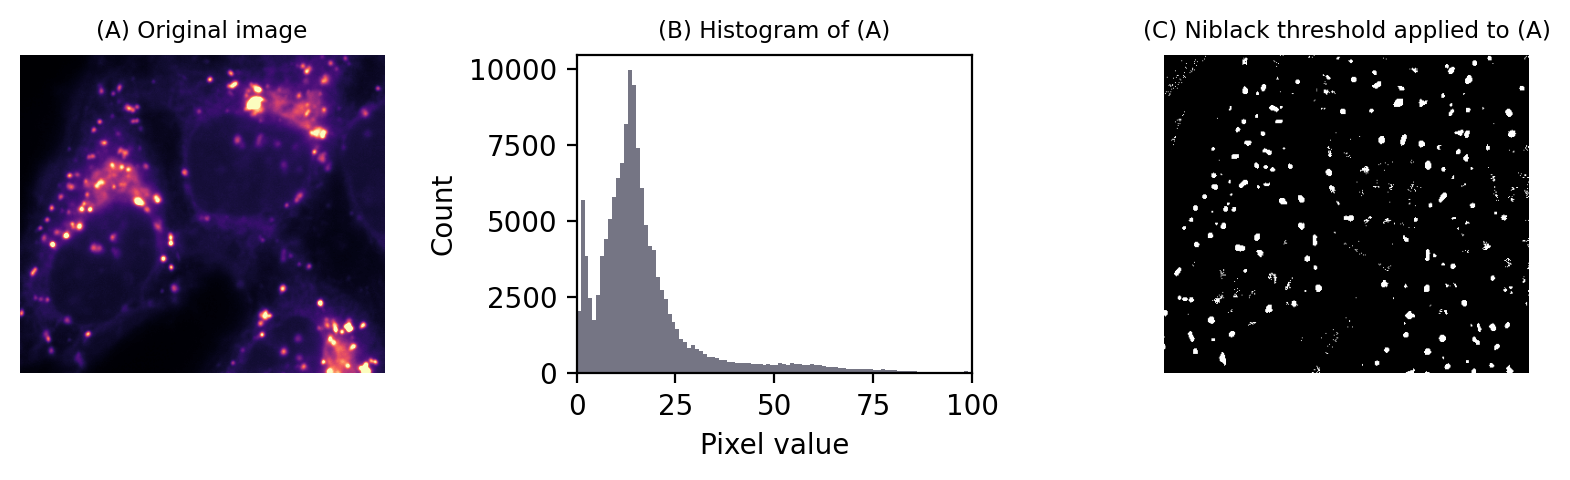

In [17]:
from skimage.filters import threshold_niblack
from skimage.morphology import disk
from matplotlib import colormaps

# Load image
im = load_image('hela-cells.zip')[50:400, 50:450, 0].astype(np.float32)
# im = im - ndimage.median_filter(im, size=25)
im -= im.min()
im = im / im.max()
im = (im * 255).astype(np.uint8)

# Apply local Niblack threshold
bw_niblack = im > threshold_niblack(im, window_size=25, k=-1.5)

# Show, using an alternative colormap to boost contrast
fig = create_figure(figsize=(8, 2.5))
cmap = colormaps['magma']

show_image(im, title="(A) Original image", clip_percentile=0.5, cmap=cmap, pos=131)
show_histogram(im, title="(B) Histogram of (A)", bins=np.arange(0, 100), pos=132)
plt.xlim([0, 100])
show_image(bw_niblack, title="(C) Niblack threshold applied to (A)", pos=133)

plt.tight_layout()
glue_fig('fig_thresholds_local_niblack', fig)

```{glue:figure} fig_thresholds_local_niblack
---
align: center
name: fig-thresholds_local_niblack
---
Local thresholding to detect spots using Niblack's method.
```

To be honest, I don't tend to use this approach for bioimages.
I find the window size and *k* parameters difficult to tune, and it suffers the problem of the mean and standard deviation not being robust.

However, local thresholding becomes more interesting and powerful if we take matters into our own hands by thinking about the problem from a slightly different angle.

Suppose we had a second image that contained values equal to the thresholds we want to apply at each pixel.
If we simply *subtract* this second image from the first, we can then apply a global threshold of 0 to detect what we want.

Alternatively, we could subtract an image with values that aren't exactly equal to the local thresholds, but similar enough to effectively flatten out the background so that a global threshold can be applied.
This then provides us access to all global automated thresholding methods, and an intuition of how the histograms ought to look for the methods to be appropriate.
{numref}`fig-thresholds_local` shows this in action.

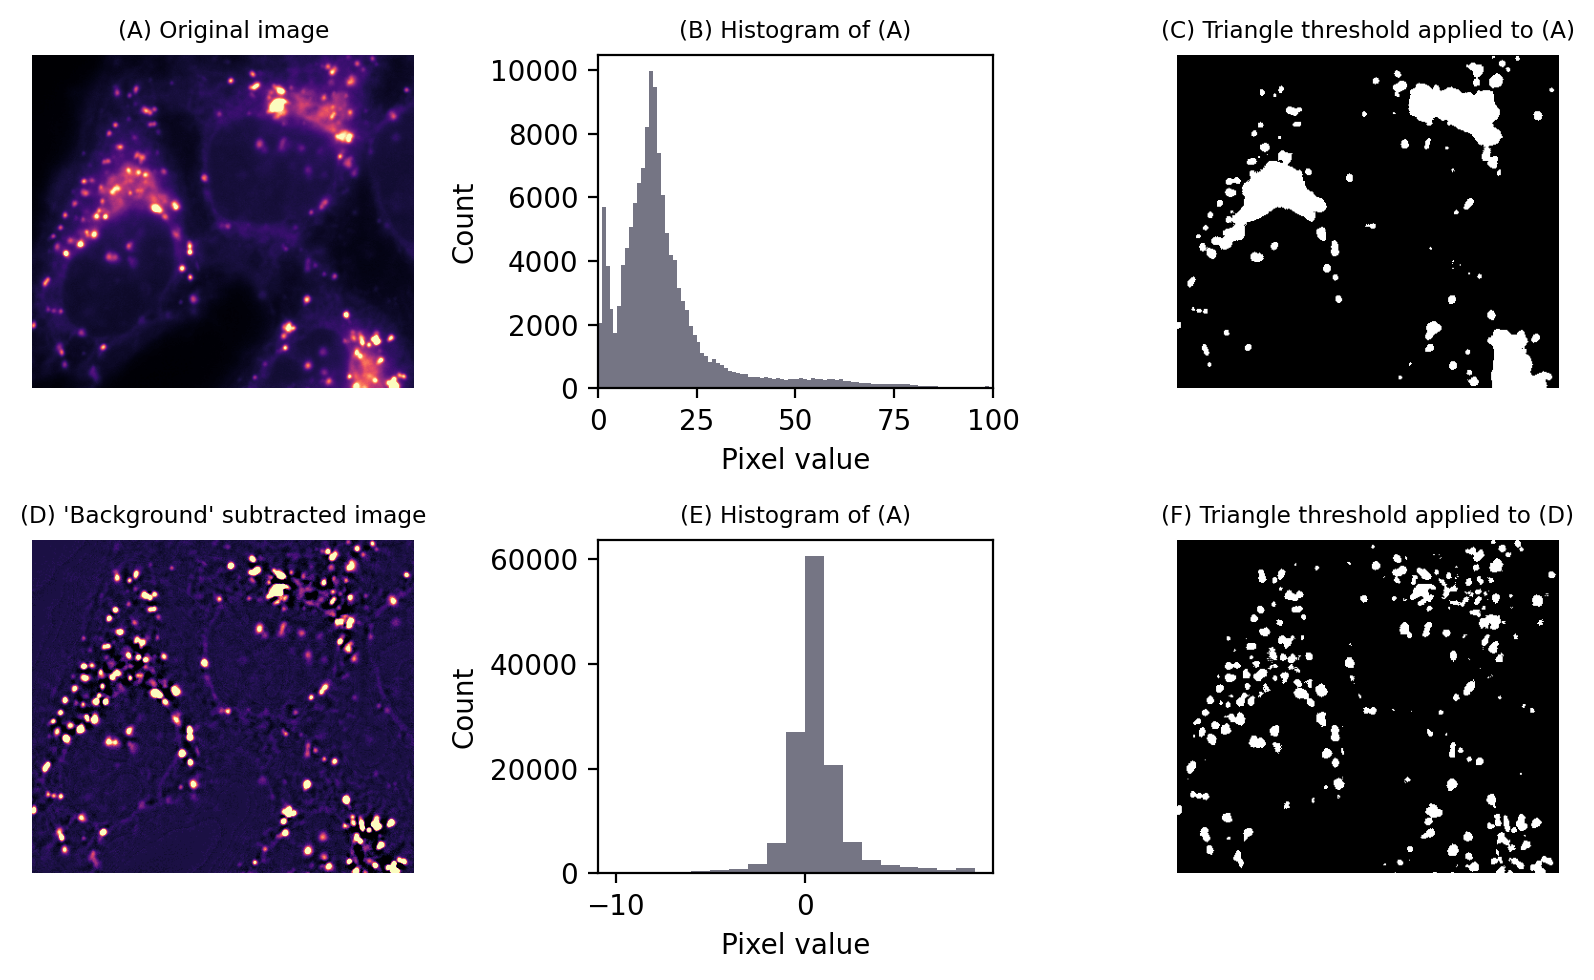

In [18]:
from skimage.filters import threshold_triangle, median
from skimage.morphology import disk

# Load image
im = load_image('hela-cells.zip')[50:400, 50:450, 0].astype(np.float32)
# im = im - ndimage.median_filter(im, size=25)
im -= im.min()
im = im / im.max()
im = (im * 255).astype(np.uint8)

# Apply triangle threshold
bw_triangle = im > threshold_triangle(im)

# Apply large median filter
im_median = median(im, footprint=disk(8))

# Subtract median-filtered image and now try triangle threshold again
im_diff = im.astype(np.float32) - im_median
bw_diff = im_diff > threshold_triangle(im_diff)

# Show, using an alternative colormap to boost contrast
fig = create_figure(figsize=(8, 5))
cmap = colormaps['magma']

show_image(im, title="(A) Original image", clip_percentile=0.5, cmap=cmap, pos=231)
show_histogram(im, title="(B) Histogram of (A)", bins=np.arange(0, 100), pos=232)
plt.xlim([0, 100])
show_image(bw_triangle, title="(C) Triangle threshold applied to (A)", pos=233)

# show_image(im_median, title="(D) Median filtered image", clip_percentile=0.5, cmap=cmap, pos=234)
show_image(im_diff, title="(D) 'Background' subtracted image", clip_percentile=2, cmap=cmap, pos=234)
show_histogram(im_diff, title="(E) Histogram of (A)", bins=np.arange(-10, 10), pos=235)
show_image(bw_diff, title="(F) Triangle threshold applied to (D)", pos=236)

plt.tight_layout()
glue_fig('fig_thresholds_local', fig)

```{glue:figure} fig_thresholds_local
---
align: center
name: fig-thresholds_local
---
Thresholding to detect structures appearing on a varying background. No global threshold may be sufficiently selective _(top row)_. However, if a 'background image' can be created, (here using a large median filter), and then subtracted, a single threshold can give much better results _(bottom row)_. This is equivalent to applying a varying threshold to the original image.
```

The difficult part is creating the second image.
Filters are the key, and the subject of the [next chapter](chap_filters).